# ADA Project: Welcome to the analysis of **Amercian Influence in the Cinema industry**

## Authors
- Group Name: ADACTYLOUS
    - Chloé Bouchiat
    - Claire Pinson
    - Germana Sergi
    - Luca Soravia
    - Marlen Stöckli

## Notebook's structure
- Main librairies and specific functions from the utils folder
- Our analysis workflow with a markdown cell explaining each code cell
- The notebook reads as follow:
    - movie.metadata enriched by IMDB ratings (coming from the IMDb non commercial datasets ([IMDb](https://developer.imdb.com/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions
    - character.metadata enriched with wikipedia actor's nationality ([DBpedia](https://www.dbpedia.org/about/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions

#### Recall of the repository structure:
```
📁 ada-2024-project-adactylous
│
├── 📄 results.ipynb (where all ours plots and analysis are)
├── 📄 .gitignore (what is ignored during push and pull requests)
├── 📄 requirements.txt (install into your environment)
├── 📄 README.md
│
├── 📁 data
       │── 📄 actor_metadata_CMU.csv
       │── 📄 movie_metadata_CMU_IMDB.csv
       │── 📄 nationality.csv
       │── 📄 personas_metadata_CMU.csv
       │── 📄 plot_summaries_CMU.csv
├── 📁 src
    ├── 📁 data
    ├── 📁 models
    ├── 📁 scripts
        │── 📄 datasets_cleaner.py
        │── 📄 nationality_importer.py
    ├── 📁 utils
└── 📁 tests
``` 
**NOTE**: Other empty folders and .py files will be filled up later on during the project.

**For any questions concerning how the data where imported and cleaned, please refer to *datasets_cleaner.py* and *nationality_importer.py***

In [6]:
# Import the needed libarairies
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans # for actors analysis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [7]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
personas_mtd = pd.read_table('data/personas_metadata_CMU.csv', sep=',')

In [8]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

# 1. Movie metadata enriched with IMDB ratings

### 1.1 General information about the dataset

#### 1.1.1 Box office revenue, runtime and IMDb analysis

The below cell is a general cell that creates "sub"-datasets to faciliate the analysis

In [9]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

Numbers of US movies in the dataset

The total number of films in the dataset is 81748.
The total number of american movies uniquely produced in the US in the dataset is 30302.
The total number of american movies partially produced in the US in the dataset is 4109.
The total number of movies strictly produced outside the US in the dataset is 39182.


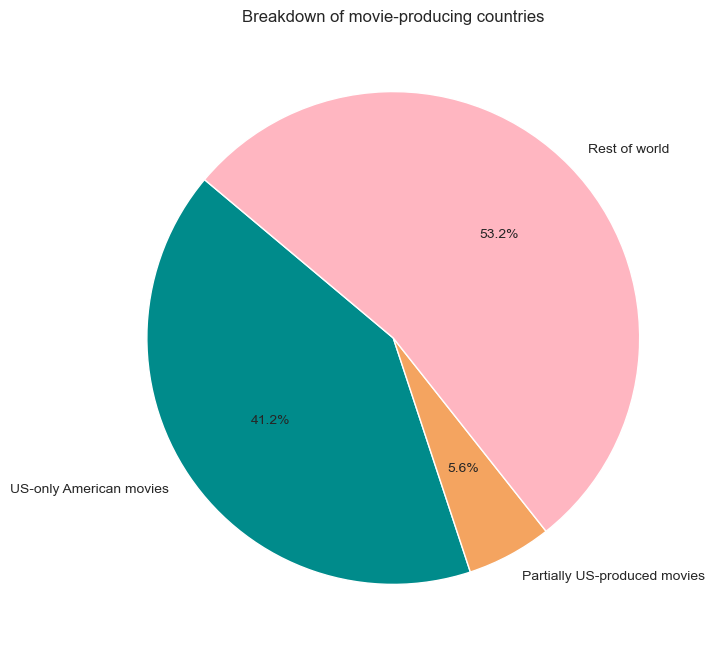

In [10]:
total_number_movies_df = len(all_movies)
# movies UNIQUELY produced in the US
total_number_US_movies = us_movies['countries'].count()

# US movies only PARTIALLY produced in the us
total_number_partial_US_movies = us_partially_movies['countries'].count()
# Non-US produced movies (ROW)
strict_rest_world_movies = rest_world_non_US['countries'].count()

print(f"The total number of films in the dataset is {total_number_movies_df}.")
print(f"The total number of american movies uniquely produced in the US in the dataset is {total_number_US_movies}.")
print(f"The total number of american movies partially produced in the US in the dataset is {total_number_partial_US_movies}.")
print(f"The total number of movies strictly produced outside the US in the dataset is {strict_rest_world_movies}.")

list_numbers_movies_granular = [total_number_US_movies, total_number_partial_US_movies, strict_rest_world_movies] 

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(
    list_numbers_movies_granular,
    labels= ['US-only American movies', 'Partially US-produced movies' , 'Rest of world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size to fit the plot area
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
plt.title("Breakdown of movie-producing countries")
plt.show()

In this initial plot, we gain an overview of the dataset in relation to our research question: whether the predominance of the U.S. in the global film industry influences the production of non-American movies. The plot reveals that 41.2% of all movies in the dataset are U.S. productions, while some are co-productions between the U.S. and other countries. Slightly more than 50% of the movies in the dataset are not produced in the U.S.

From this, we deduce that the U.S. has a direct influence on about half of the movies in the dataset, as it is the country of production. This observation emphasizes the relevance of studying the U.S.'s influence on global cinema  and we can dive into the detailed analysis.

Box office analysis
- One states here that column 'country' from the CMU dataset represents the country of production of the movie.

Basic stats

In [11]:
# Whole dataset
basic_stats_box_office_all_movies = all_movies['box_office'].describe()
# American movies STRICTLY produced in the US
basic_stats_box_office_US = us_movies['box_office'].describe()
# American movies PARTIALLY produced in the US
basic_stats_box_office_US_partial = us_partially_movies['box_office'].describe()
# Rest of world (= Non Us movies)
basic_stats_box_office_ROW = rest_world_non_US['box_office'].describe()

dict_results = {'All movies': [basic_stats_box_office_all_movies.loc['50%'], basic_stats_box_office_all_movies.loc['mean'], basic_stats_box_office_all_movies.loc['std'], basic_stats_box_office_all_movies.loc['max'], basic_stats_box_office_all_movies.loc['min']], 
                'US-only produced': [basic_stats_box_office_US.loc['50%'], basic_stats_box_office_US.loc['mean'], basic_stats_box_office_US.loc['std'], basic_stats_box_office_US.loc['max'], basic_stats_box_office_US.loc['min']], 
                'Partially US-produced': [basic_stats_box_office_US_partial.loc['50%'], basic_stats_box_office_US_partial.loc['mean'], basic_stats_box_office_US_partial.loc['std'], basic_stats_box_office_US_partial.loc['max'], basic_stats_box_office_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_box_office_ROW.loc['50%'], basic_stats_box_office_ROW.loc['mean'], basic_stats_box_office_ROW.loc['std'], basic_stats_box_office_ROW.loc['max'], basic_stats_box_office_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
# To display only 2 decimals after the comma taking advantage of the Jupyter notebook environment
df_basic_stat_box_office.style.format("{:.2f}") 

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median (millions USD),10.64,10.76,23.00,5.19
mean (millions USD),48.00,48.81,76.13,16.81
std (millions USD),112.17,110.40,153.26,34.99
max (millions USD),2782.28,2185.37,2782.28,377.91
min (millions USD),0.01,0.01,0.01,0.01


In [12]:
print(all_movies[all_movies['box_office'] >= 2.78e+09][['title', 'release_year']])

        title  release_year
23705  Avatar        2009.0


By looking at the above data frame containing basic statistics on box office revenue, one can hihglight the following points: 

first, one sees that the median is around 10 millions dollars for both US-only produced and all the movies produced worlwide in the dataset. US-partially produced movies show a two times higher median. This observation is logical if one observes the maximum value of box office. This value corresponds to the first Avatar movie (cf. above cell) and it clearly helps increasing the mean of US-partially produced movies. 
Furthermore, by looking at the above table, one can already mention that producing a film only partially in the US seems lead to higher box office revenue. 
Finally, the non-US produced movies generate much less box office revenue by looking at the mean and the median. Indeed, the median is nearly five times lower than US-partially produced movies and two times lower than US-only produced movies. For the mean, the factors are 4.75 and 3 lower for Non-US movies, respectively.

**By analyzing basic stats on box office revenue, one obtains the first clues that show the benefits in terms of box office revenue of producing movies in the US strictly or even better, producing them only partially in the US. One recalls that these observations are not prooving any causality.**

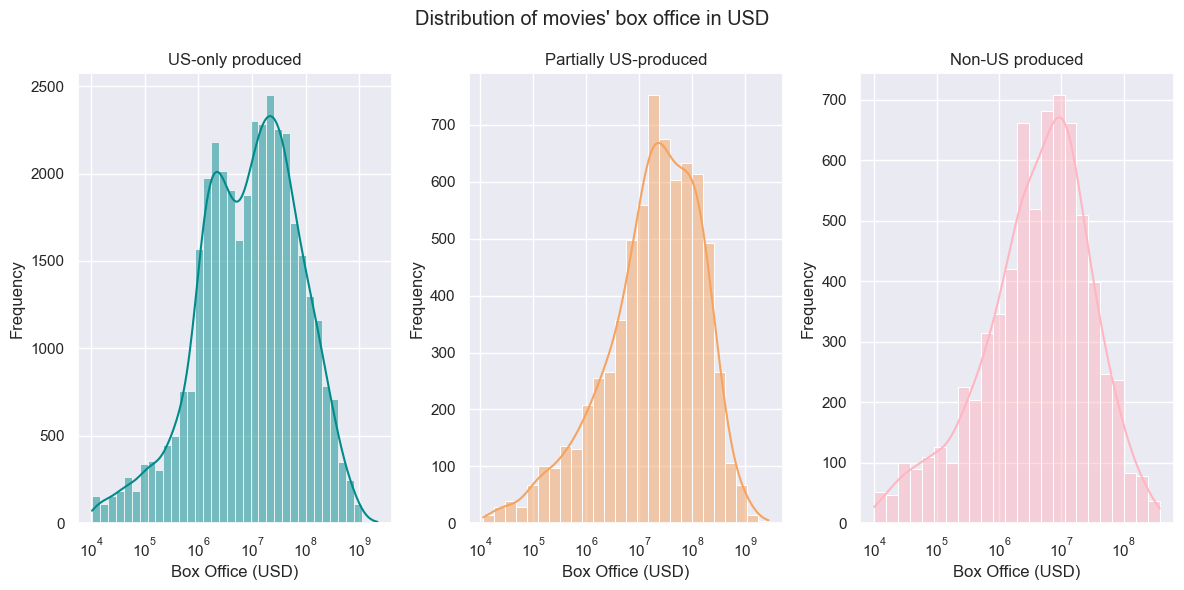

In [13]:
# First visualization of the distribution of 

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_movies['box_office'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= True, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small bins if no log scale used
axes[0].set_xlabel("Box Office (USD)")
sns.histplot(us_partially_movies['box_office'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= True, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Box Office (USD)")
sns.histplot(rest_world_non_US['box_office'], kde=True, stat='frequency', bins = 'auto', color='lightpink', cumulative = False, log_scale= True, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Box Office (USD)")
fig.suptitle("Distribution of movies' box office in USD") # to avoid any overlapping
fig.tight_layout()
plt.show()

Without using a log-scale (not displayed here), one immediately sees that the box office values in USD follow a heavy-tailed distribution. Indeed, a few films generated about one billion USD while the vast majority generated around 50 to 100 million dollars (cf. basic stats section above). Furthermore, the distribution is right-skewed. This means that the mean and standard deviation over the whole dataset are quite meaningless.
So one uses a logarithmic x-axis to better capture the different distributions. By looking at the three above charts, one observes that US movies (both only and partially produced in the US) generate box office revenue ranging between 10'000 and about 1 billion dollars. On the other hand, the movies' box office produced in the rest of the world only range between 10'000 and about 100 millions dollars.

Runtime analysis

**Hypothesis**
- Runtimes
    - one chooses to discard the films lasting more than 180 minutes (3h) since they represent only about 1 % of the dataset (see below).
        - some films exist but are extremely long as for example *Modern Times Forever* that lasts 10 days (14'400 minutes) (see https://en.wikipedia.org/wiki/Modern_Times_Forever_(Stora_Enso_Building,_Helsinki))
    - one chooses to keep the films lasting less than 60 minutes (1h) since a lot of short film made in the 20s and in the 40s are very short.
- Box office values
    - one chooses to discard all the NaN values to ease the plotting (more details in section 1.2, *Box office timeseries analysis*)

In [14]:
movies_longer_3h = movie_mtd[movie_mtd['runtime'] > 180.0]['runtime'].count()
movies_shorter_1h = movie_mtd[movie_mtd['runtime'] < 60.0]['runtime'].count()

print(f"Number of films lasting more than 3 hours (180 minutes) in the whole dataset: {movies_longer_3h} which corresponds to {(movies_longer_3h/len(movie_mtd))*100:.2f} % of the dataset ({len(movie_mtd)} lines in total).")
print(f"Number of films lasting less than 1 hour (60 minutes) in the whole dataset: {movies_shorter_1h} which corresponds to {(movies_shorter_1h/len(movie_mtd))*100:.2f} % of the dataset ({len(movie_mtd)} lines in total).")

Number of films lasting more than 3 hours (180 minutes) in the whole dataset: 806 which corresponds to 0.99 % of the dataset (81748 lines in total).
Number of films lasting less than 1 hour (60 minutes) in the whole dataset: 6774 which corresponds to 8.29 % of the dataset (81748 lines in total).


Investigating the NaN in the *runtime* column

In [15]:
nan_number_all_movies_runtime = movie_mtd['runtime'].isna().sum(axis = 0)
print(f"The number of NaN in the 'runtime' column is {nan_number_all_movies_runtime}")
print(f"Proportion of NaN runtime values in the whole dataset: {(nan_number_all_movies_runtime/len(movie_mtd))*100:.2f} %.")

The number of NaN in the 'runtime' column is 20452
Proportion of NaN runtime values in the whole dataset: 25.02 %.


Discarding the films longer than 180 minutes as stated above <br>
**This cell automatocally drop the lines of the dataframe *movie_mtd* where the condition is not met**

In [16]:
# Discard the films longer than 180 minutes.It automatically discards the NaN values also since they don't "meet" de below condition
# by creating new dataframe (using the .copy() syntax)
all_movies_runtime = all_movies[(all_movies['runtime'] <= 180.0)].copy()
us_movies_runtime = us_movies[(us_movies['runtime'] <= 180.0)].copy()
us_partially_movies_runtime = us_partially_movies[(us_partially_movies['runtime'] <= 180.0)].copy()
all_us_movies_runtime = all_us_movies[(all_us_movies['runtime'] <= 180.0)].copy()
rest_world_non_US_runtime = rest_world_non_US[(rest_world_non_US['runtime'] <= 180.0)].copy()

print(f"US-only produced movies dataframe's shape before removing the films bigger {us_movies.shape} and after {us_movies_runtime.shape}.")
print(f"US partially-produced movies dataframe's shape before removing the films bigger {us_partially_movies.shape} and after {us_partially_movies_runtime.shape}.")
print(f"Non-US produced (ROW) movies dataframe's shape before removing the films bigger {rest_world_non_US.shape} and after {rest_world_non_US_runtime.shape}.")

US-only produced movies dataframe's shape before removing the films bigger (30302, 13) and after (25337, 13).
US partially-produced movies dataframe's shape before removing the films bigger (4109, 13) and after (3838, 13).
Non-US produced (ROW) movies dataframe's shape before removing the films bigger (39182, 13) and after (27782, 13).


Basic stats (using the new datasets that discard movies lasting more than 180 minutes)

In [17]:
# Whole dataset
basic_stats_runtime_all_movies = all_movies_runtime['runtime'].describe()
# American movies STRICTLY produced in the US
basic_stats_runtime_US = us_movies_runtime['runtime'].describe()
# American movies PARTIALLY produced in the US
basic_stats_runtime_US_partial = us_partially_movies_runtime['runtime'].describe()
# Rest of world (= Non Us movies)
basic_stats_runtime_ROW = rest_world_non_US_runtime['runtime'].describe()

dict_results = {'All movies': [basic_stats_runtime_all_movies.loc['50%'], basic_stats_runtime_all_movies.loc['mean'], basic_stats_runtime_all_movies.loc['std'], basic_stats_runtime_all_movies.loc['max'], basic_stats_runtime_all_movies.loc['min']], 
                'US-only produced': [basic_stats_runtime_US.loc['50%'], basic_stats_runtime_US.loc['mean'], basic_stats_runtime_US.loc['std'], basic_stats_runtime_US.loc['max'], basic_stats_runtime_US.loc['min']], 
                'Partially US-produced': [basic_stats_runtime_US_partial.loc['50%'], basic_stats_runtime_US_partial.loc['mean'], basic_stats_runtime_US_partial.loc['std'], basic_stats_runtime_US_partial.loc['max'], basic_stats_runtime_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_runtime_ROW.loc['50%'], basic_stats_runtime_ROW.loc['mean'], basic_stats_runtime_ROW.loc['std'], basic_stats_runtime_ROW.loc['max'], basic_stats_runtime_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (minutes)', 'mean (minutes)', 'std (minutes)', 'max (minutes)', 'min (minutes)'])
df_basic_stat_box_office.style.format("{:.2f}") # to display only 2 decimals after the comma taking advantage of the Jupyter notebook environment

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median (minutes),93.00,90.00,97.00,96.00
mean (minutes),91.20,83.92,99.27,97.56
std (minutes),30.80,29.55,23.15,30.43
max (minutes),180.00,180.00,180.00,180.00
min (minutes),0.00,0.00,0.00,0.03


One observes that for all the different categories of production the median is located around 95 minutes. The mean is a bit higher, around 100 minutes. The standard deviation is around 30 minutes for the whole dataset which is big since some films are very short. Indeed the first movies back in the 20s were very short films lasting less than 60 minutes. Partially US-produced movies show a lower standard deviation. Finally, the maximal duration of films is 180 minutes for all films which shows that the discarding of movies lasting more than 180 minutes has been successful.

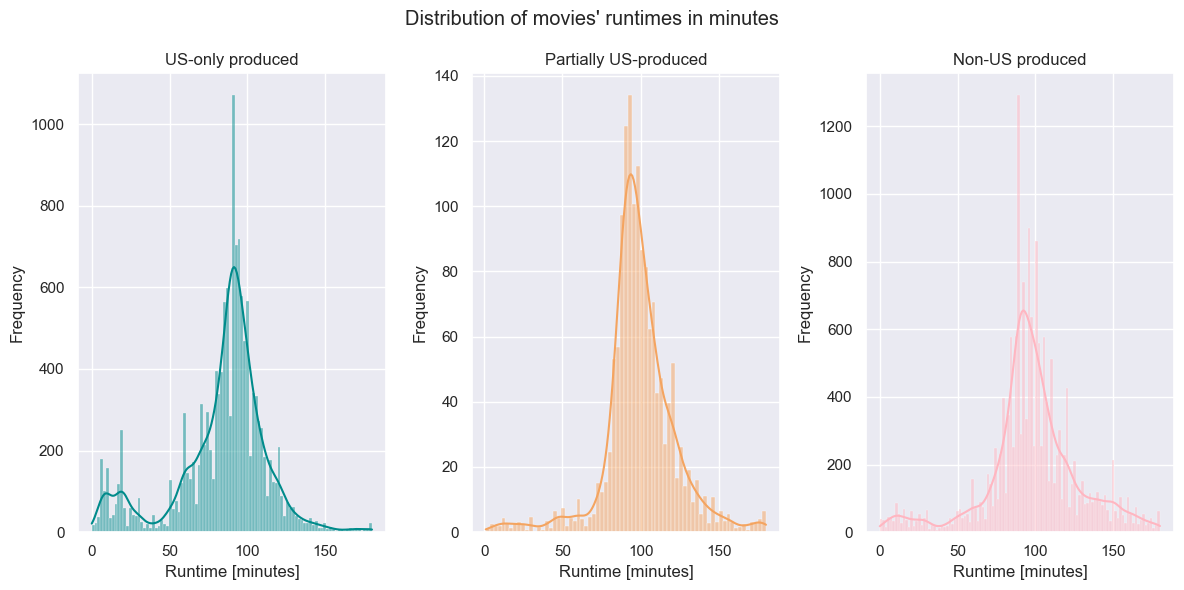

In [18]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_movies_runtime['runtime'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= False, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Runtime [minutes]")
sns.histplot(us_partially_movies_runtime['runtime'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Runtime [minutes]")
sns.histplot(rest_world_non_US_runtime['runtime'], kde=True, stat='frequency', bins = 'auto', color='lightpink', cumulative = False, log_scale= False, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Runtime [minutes]")
fig.suptitle("Distribution of movies' runtimes in minutes")
fig.tight_layout()
plt.show()

For US-only, partially-US and Non-US produced movies, the distribution seems to follow more or less a normal distribution centered around 100 minutes (1h40). US-only produced movies' distribution shows a bimodal distribution with a small mode around 20 minutes. Once again this might be because of the silent and short movies that launched the cinema industry back in the 20s-30s. Indeed, in this plots there is no information about the release year of the movies.

Average IMDb ratings analysis

Basic stats

In [19]:
# whole dataset
basic_stats_averageRating_all_movies = all_movies['averageRating'].describe()
# american movies STRICTLY produced in the US
basic_stats_averageRating_US = us_movies['averageRating'].describe()
# american movies PARTIALLY produced in the US
basic_stats_averageRating_US_partial = us_partially_movies['averageRating'].describe()
# Rest of world (= Non Us movies)
basic_stats_averageRating_ROW = rest_world_non_US['averageRating'].describe()

dict_results = {'All movies': [basic_stats_averageRating_all_movies.loc['50%'], basic_stats_averageRating_all_movies.loc['mean'], basic_stats_averageRating_all_movies.loc['std'], basic_stats_averageRating_all_movies.loc['max'], basic_stats_averageRating_all_movies.loc['min']], 
                'US-only produced': [basic_stats_averageRating_US.loc['50%'], basic_stats_averageRating_US.loc['mean'], basic_stats_averageRating_US.loc['std'], basic_stats_averageRating_US.loc['max'], basic_stats_averageRating_US.loc['min']], 
                'Partially US-produced': [basic_stats_averageRating_US_partial.loc['50%'], basic_stats_averageRating_US_partial.loc['mean'], basic_stats_averageRating_US_partial.loc['std'], basic_stats_averageRating_US_partial.loc['max'], basic_stats_averageRating_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_averageRating_ROW.loc['50%'], basic_stats_averageRating_ROW.loc['mean'], basic_stats_averageRating_ROW.loc['std'], basic_stats_averageRating_ROW.loc['max'], basic_stats_averageRating_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median [-]', 'mean [-]', 'std [-]', 'max [-]', 'min [-]'])
df_basic_stat_box_office.style.format("{:.1f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median [-],6.3,6.2,6.3,6.3
mean [-],6.2,6.1,6.2,6.3
std [-],1.1,1.0,1.1,1.1
max [-],10.0,9.5,9.2,10.0
min [-],1.4,1.4,1.4,1.5


Looking at the basic statistics on average IMDb ratings, one notices that the mean and median are quite similar for all production types which indicates that the data is not skewed and that it likely follows a normal distribution (cf. below cell). One will verify this hypotehsis in section 1.2, *Statistical Test* (see below). The standard deviation is also similar across all production types.

**To conclude, producing a movie only or partially in the US does not seem to lead to higher ratings on average by the public.**

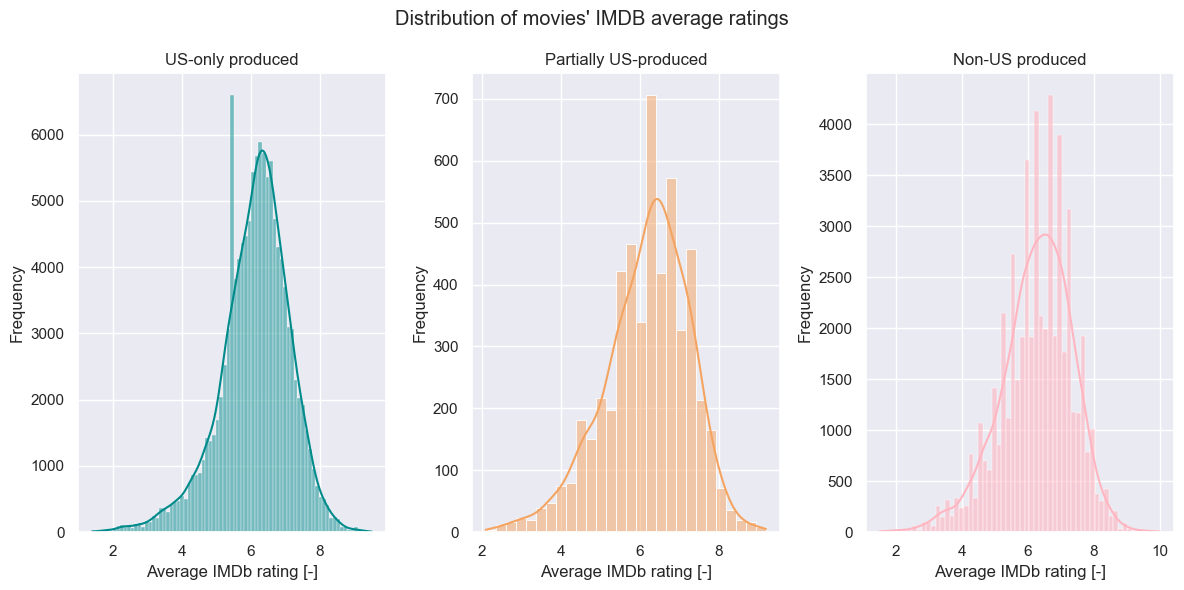

In [20]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
# bins = 'auto' produces too small bins if no log scale used
sns.histplot(us_movies['averageRating'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= False, ax=axes[0]).set(title="US-only produced") 
axes[0].set_xlabel("Average IMDb rating [-]")
sns.histplot(us_partially_movies['averageRating'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Average IMDb rating [-]")
sns.histplot(rest_world_non_US['averageRating'], kde=True, stat='frequency', bins = 'auto', color='lightpink', cumulative = False, log_scale= False, ax=axes[2], alpha = 0.6).set(title="Non-US produced") 
axes[2].set_xlabel("Average IMDb rating [-]")
fig.suptitle("Distribution of movies' IMDB average ratings")
fig.tight_layout()
plt.show()

The histogram for the average IMDb rating for US-only produced movies seems to follow a normal distribution. A weird bar is to be observed at around an average IMDb rating of 5.5 which can be due to diverse factors inherent to how the rating is implemented in the IMDb dataset. On the contrary, the average IMDb rating for partially US-produced and Non-US produced movies are slithly right skewed. Furthermore, as seen in the basic stats section, most of the movies ratings are located around 6 with proportionnally fewer ratings above 8.

#### 1.1.2 Translations analysis

##### How to work with the 'language' column ?

Some languages do not contain the word "Language" (i.e. nan, different case, or just not mentionned). Hence, to count the number of translations, we choose the count the number of comma in the cells of the column 'languages'.

To get some examples of languages that do not contain the world "Language" in this colomn, please run this line : <br>
print(movie_mtd[movie_mtd['languages'].apply(lambda x: x.count('Language')==0 if isinstance(x, str) else True)]['languages'].unique()[:10])

Proportion of movies available at least in 2 languages: 0.12
Proportion of movies available at least in 2 languages, but not in English: 0.03
Proportion of movies available at least in 2 languages, including English: 0.09
Proportion of silent movies: 0.04
Proportion of movies available at least in English: 0.50
Proportion of movies available only in English: 0.41


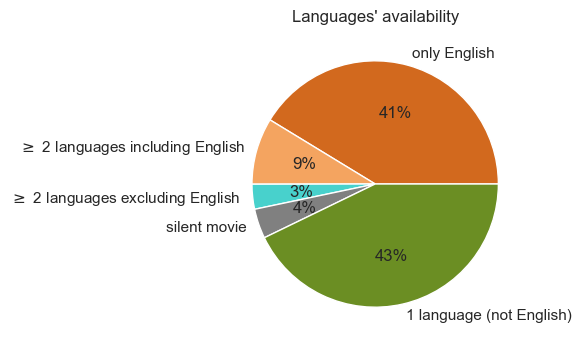

In [21]:
######################################## EXPLORATORY ANALYSIS OF THE TRANSLATIONS ####################################

# Count number of movies available in at least 2 languages
def fct_2L_available(x):
    if isinstance(x, str):
        if x.count(',')>=1: # each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True 
        else :
            return False
    else :
        return False

count_2L=movie_mtd['languages'].apply(lambda x:  fct_2L_available(x)).sum()
print(f'Proportion of movies available at least in 2 languages: {count_2L/len(movie_mtd):.2f}')


# Count number of movies available in at least 2 languages, but not available in English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" not in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else :
            return False
    else :
        return False

count_2LnotE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, but not in English: {count_2LnotE/len(movie_mtd):.2f}')


#count number of movies available in at least 2 languages, including English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else : 
            return False
    else :
        return False

count_2L_E=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, including English: {count_2L_E/len(movie_mtd):.2f}')


#the case of silent movies : we could consider that they are available in all languages, but it is surely negligeable...
count_silent=movie_mtd['languages'].apply(lambda x: 'silent film' in x.lower() if isinstance(x, str) else False).sum()
print(f'Proportion of silent movies: {count_silent/len(movie_mtd):.2f}')
#they are not that negligeable...


#proportion of movies available in English

#calculate proportion of movies available in English
def english_available(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) :
            return True
        else :
            return False
    else :
        return False

count_E = movie_mtd['languages'].apply(lambda x: english_available(x)).sum()  
print(f'Proportion of movies available at least in English: {count_E/len(movie_mtd):.2f}')


#proportion of movies available only in English
def fct(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) and x.count(',')==0 : 
            return 1
        else :
            return 0
    else :
        return 0
count_onlyE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available only in English: {count_onlyE/len(movie_mtd):.2f}')

############################################# PIE CHARTS ############################################### 
rest=100-count_onlyE*100/len(movie_mtd)- count_2LnotE*100/len(movie_mtd)- (count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd))-count_silent*100/len(movie_mtd)

data = [count_onlyE*100/len(movie_mtd),  count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd), count_2LnotE*100/len(movie_mtd),count_silent*100/len(movie_mtd), rest] 
keys = ['only English', '$\geq$ 2 languages including English', '$\geq$ 2 languages excluding English', 'silent movie', '1 language (not English)'] 
plt.figure(figsize=(4, 4))
sns.set_theme(style="darkgrid")
plt.title("Languages' availability")
# plot a pie chart
plt.pie(data, labels=keys, colors=['chocolate','sandybrown','mediumturquoise','grey','olivedrab'], autopct='%.0f%%')  
plt.show() 

We observe on the figure above that 50% of the movies are available in English. Assuming that most of Americain people only speak fluently English, that means that "only" half of the produced movies are accessible to this population. Hence, we could be wondering if a movie available in English (i.e. whose public includes Americain people) generates more money than a movie not available in English ? 

How different is the box office revenue for movies available in English vs not available in English ? is it significant ?

The calculated p-value is 4.13e-10.
The difference in means is statistically significant for an alpha-level of 0.05.


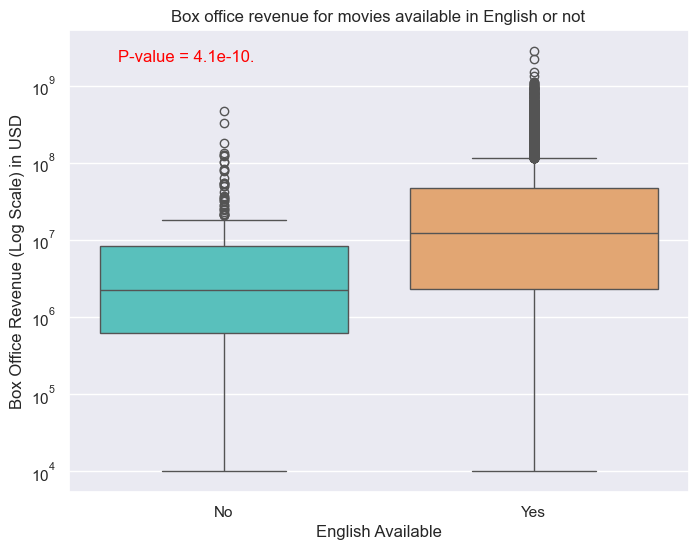

In [22]:
# Auxiliary fonction to detect if the movie is available in English
def fct(x):
    if isinstance(x, str):
        if "english"  in x.lower() : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return 1
    else :
        return 0
# Creation of an extra column containing 1 is English is available in the languages, 0 if not. 
movie_mtd['english available']=movie_mtd['languages'].apply(lambda x: fct(x))

######################################## Statistical test ##############################################""
# Are the means significantly different ?
# Null hypothesis HO: the means of the two populations (English available and not available) are not significantly different.
# Alternative hypotehsis HA: the means of the two populations (English available and not available) are significantly different.

alpha=0.05
statistic, p_value=ttest_ind(movie_mtd[movie_mtd['english available']==1]['box_office'].dropna(), movie_mtd[movie_mtd['english available']==0 ]['box_office'].dropna())
print(f'The calculated p-value is {p_value:.2e}.')
if p_value<alpha :
    print(f'The difference in means is statistically significant for an alpha-level of {alpha}.')
else :
    print(f'The difference in means is NOT statistically significant for an alpha-level of {alpha}.')

############################################# Plot ###############################################
plt.figure(figsize=(8, 6))
ax=sns.boxplot(movie_mtd, x='english available', y='box_office', palette=['mediumturquoise','sandybrown'])
plt.yscale('log') # because otherwise the outliers are overwhelming in the plot
plt.title('Box office revenue for movies available in English or not')
plt.suptitle('') # to remove the automatic subtitle of .boxplot
ax.set_xticklabels(['No','Yes'])
plt.xlabel('English Available')
plt.ylabel('Box Office Revenue (Log Scale) in USD')
# the x and y positions are in the images coordinates (log scale x linear scale)
ax.text(0.1, 2*10**9, f'P-value = {p_value:.1e}.', ha='right', fontsize=12, color='red')
plt.show()


The p-value is really low, significantly lower than even 1%, so we can conclude that the mean box office revenues' of the two groups are significantly different. Hence, movies available in English generate in average more money that movies not available in English. However, that does NOT mean that a there is a causality relation. 

Let's observe the distribution of released movies over time.

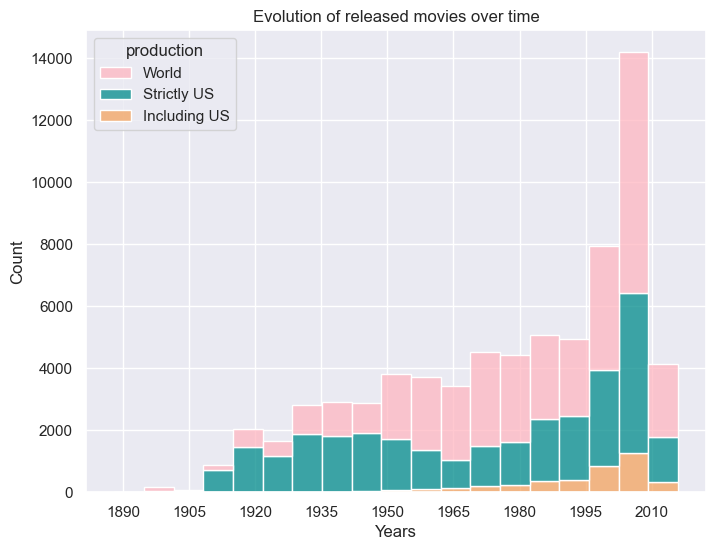

In [23]:
# Parameters
num_bins=20
bin_edges = np.linspace(min(movie_mtd['release_year']), max(movie_mtd['release_year']), num_bins)

# To use the 'hue' argument in sns.histplot, we need to add a column that contains the same value for respectively each dataset
rest_world_non_US['production'] = 'World'
us_movies['production'] = 'Strictly US'
us_partially_movies['production'] = 'Including US'

# Plot
fig, ax = plt.subplots(figsize = (8,6))
# Pass the concatenation to sns.histplot, then split with the 'hue' parameter to stack each category on top of each other
# The legend is added directly in this line
sns.histplot(data=pd.concat([rest_world_non_US, us_movies, us_partially_movies]), x='release_year', hue='production', multiple='stack', bins=bin_edges, palette=['lightpink', 'darkcyan', 'sandybrown'], legend="brief")

ax.xaxis.set_major_locator(MaxNLocator(10))
plt.title('Evolution of released movies over time')
plt.xlabel('Years')
plt.show()

- We observe the a rapid increase around 1910;
- then a plateau during the Second World War (1939-1945);
- after WWII, the production of worlwide movies decreased slightly;
- around 1970, the production is increasing again and we observe the emergence of movies produced by of collaboration between US and other countries;
- finally, around 2000, there is a worlwide peak in movie production.

NB: Within this plot, each bar has the same width in years. In particular, the upper bound of the last bar is 2016, the release year of the newest movie of the dataset. Therefore, the drop in number of released movies before 2016 is not due to a boundary effect, but is actually observed in the data.

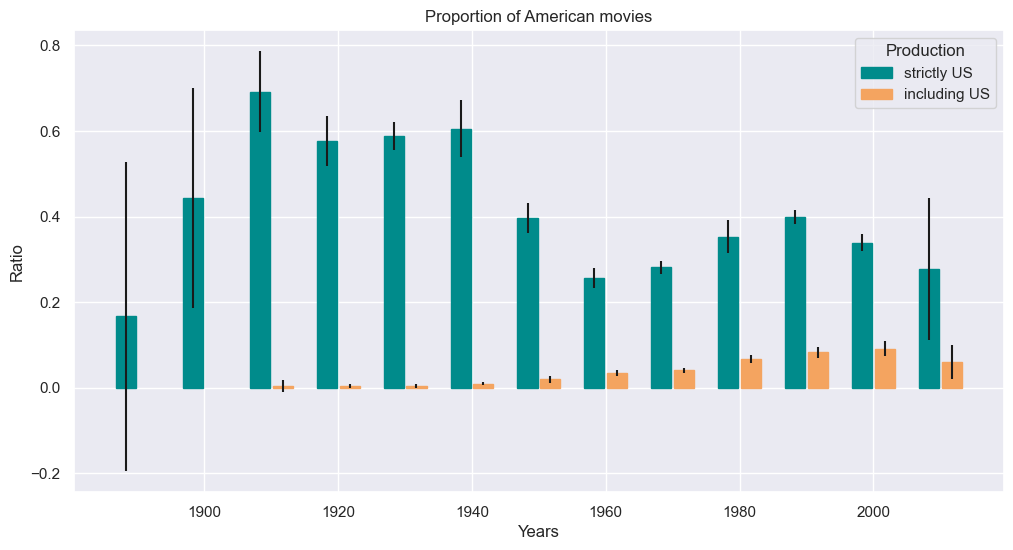

In [24]:
# Plot of the evolution of the proportion of americain movies over time

#calculate proportions per decade
prop_incl_us=((us_partially_movies.groupby(us_partially_movies['release_year']//10)['wiki_movie_ID'].count())/(movie_mtd.groupby(movie_mtd['release_year']//10)['wiki_movie_ID'].count()))
prop_strict_us=(us_movies.groupby(us_movies['release_year']//10)['wiki_movie_ID'].count())/(movie_mtd.groupby(movie_mtd['release_year']//10)['wiki_movie_ID'].count())

########################################### Calculated the standard deviations #####################################
# To do so, we need to groupby the deacdes (as chosen above), based on the ratio for each year

years_ratio_partillyus_vs_world=(us_partially_movies.groupby(us_partially_movies['release_year'])['wiki_movie_ID'].count())/(movie_mtd.groupby(movie_mtd['release_year'])['wiki_movie_ID'].count())
years_ratio_strictus_vs_world=(us_movies.groupby(us_movies['release_year'])['wiki_movie_ID'].count())/(movie_mtd.groupby(movie_mtd['release_year'])['wiki_movie_ID'].count())
# There are nans in the years where there were no US movies => we replace them with zeros since it means the ratio is zero
years_ratio_partillyus_vs_world=years_ratio_partillyus_vs_world.fillna(0)
years_ratio_strictus_vs_world=years_ratio_strictus_vs_world.fillna(0)

# We choose to calculate beforehand the decade corresponding to each row of the created dataset (same for both datasets) 
corresponding_decades = years_ratio_partillyus_vs_world.index // 10 * 10 #.index to access the year resulting from the groupby
# calculating the std dev
yerr_partially_us=years_ratio_partillyus_vs_world.groupby(corresponding_decades).std()
yerr_strict_us=years_ratio_strictus_vs_world.groupby(corresponding_decades).std()


################################################ Plot #################################################
#parameters
bins=np.arange((min(movie_mtd['release_year'])//10)*10, ((max(movie_mtd['release_year']))//10)*10+10,10)
width=3
shift=1.7

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(bins-shift, prop_strict_us, yerr=yerr_strict_us, width=width, color = 'darkcyan', edgecolor='darkcyan', label='strictly US')
plt.bar(bins+shift, prop_incl_us, yerr=yerr_partially_us, width=width, color = 'sandybrown', edgecolor='sandybrown', label='including US')
plt.title('Proportion of American movies')
plt.legend(title='Production', loc='upper right')
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.show()

Up to the 40's, the US were producing the great majority of the movies worlwide. This tendancy changes in the 50's, and the US from there on produced by themselves about only 30% of the movies worlwide. At the same moment, the movies partially produced by the US rised. If both impacts are considered, the US are still producing about 40% of the movies since the 50's.

### 1.2 Exploratory analysis of the dataset according to our research questions

#### 1.2.1 Box office timeseries analysis

Investigating the NaN values in the *box_office* column

In [25]:
nan_number_all_movies_box_office = all_movies['box_office'].isna().sum(axis = 0)
nan_number_US_movies_box_office = us_movies['box_office'].isna().sum(axis = 0)
nan_number_partially_US_movies_box_office = us_partially_movies['box_office'].isna().sum(axis = 0)
nan_number_ROW_box_office = rest_world_non_US['box_office'].isna().sum(axis = 0)
print(f"Proportion of NaN box office values in the whole dataset: {(nan_number_all_movies_box_office/len(all_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for US-only produced movies : {(nan_number_US_movies_box_office/len(us_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for US-only produced movies : {(nan_number_partially_US_movies_box_office/len(us_partially_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for non-US (ROW) produced movies : {(nan_number_ROW_box_office/len(rest_world_non_US))*100:.2f} %.")

Proportion of NaN box office values in the whole dataset: 89.72 %.
Proportion of NaN box office values for US-only produced movies : 81.90 %.
Proportion of NaN box office values for US-only produced movies : 64.64 %.
Proportion of NaN box office values for non-US (ROW) produced movies : 96.62 %.


One can immediately see that the proportion of Nan values is **very high** so one **chooses to drop the lines containing NaN values for the timeseries analysis**. The data loss is high but it will allow to produce clearer plots. Furthermore, since the CMU movies Corpus dataset needs to remain our primary dataset, one cannot enrich all the missing NaN values with an additional dataset. See the below cell for more details.

In [26]:
# Drop NaN values ONLY (using the parameter subset) from the 'box_office'& 'release_year' since we are doing time series
rest_world_non_US = rest_world_non_US.dropna(subset=['box_office', 'release_year'])
us_movies = us_movies.dropna(subset=['box_office', 'release_year'])
us_partially_movies = us_partially_movies.dropna(subset=['box_office', 'release_year'])

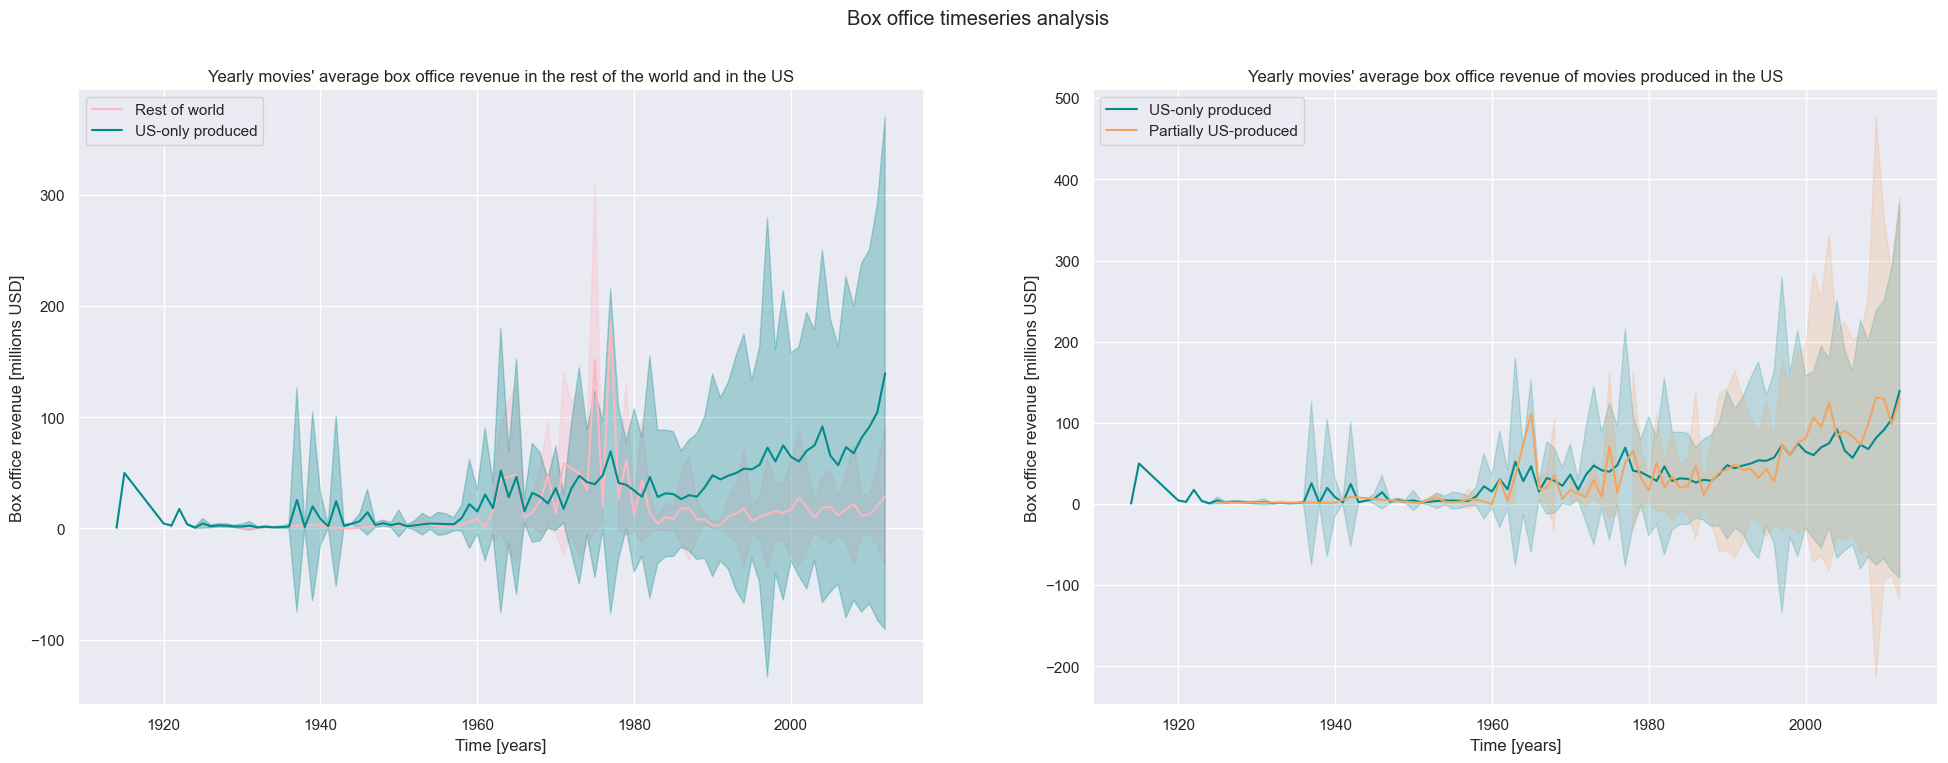

In [27]:
# average box office revenue for all movies per year world wide
avrg_ROW_box_office_per_year = rest_world_non_US.groupby('release_year')['box_office'].mean()
std_ROW_box_office_per_year = rest_world_non_US.groupby('release_year')['box_office'].std()

# average box office revenue for all movies per year in the US (movies STRICTLY produced in the US)
avrg_us_box_office_per_year = us_movies.groupby('release_year')['box_office'].mean()
std_us_box_office_per_year = us_movies.groupby('release_year')['box_office'].std()

# average box office revenue for all movies per year in the US (movies PARTIALLY produced in the US)
avrg_us_partial_box_office_per_year = us_partially_movies.groupby('release_year')['box_office'].mean()
std_us_partial_box_office_per_year = us_partially_movies.groupby('release_year')['box_office'].std()

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (24,8))
# US-only produced vs ROW
ax[0].plot(rest_world_non_US['release_year'].drop_duplicates().sort_values(), avrg_ROW_box_office_per_year/(1e6), label = 'Rest of world', color = 'lightpink')
ax[0].fill_between(rest_world_non_US['release_year'].drop_duplicates().sort_values(), y1= (avrg_ROW_box_office_per_year - std_ROW_box_office_per_year)/(1e6), y2 = (avrg_ROW_box_office_per_year + std_ROW_box_office_per_year)/(1e6), linestyle='-', color='lightpink', alpha=0.3)
ax[0].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_box_office_per_year/(1e6), label = 'US-only produced', color = 'darkcyan')
ax[0].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_box_office_per_year - std_us_box_office_per_year)/(1e6), y2 = (avrg_us_box_office_per_year + std_us_box_office_per_year)/(1e6), linestyle='-', color='darkcyan', alpha=0.3)
ax[0].set_title("Yearly movies' average box office revenue in the rest of the world and in the US")
ax[0].set_xlabel("Time [years]")
ax[0].set_ylabel("Box office revenue [millions USD]")
ax[0].legend()

# US-only produced vs partially US-produced
ax[1].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_box_office_per_year/(1e6), label = 'US-only produced', color='darkcyan')
ax[1].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_box_office_per_year - std_us_box_office_per_year)/(1e6), y2 = (avrg_us_box_office_per_year + std_us_box_office_per_year)/(1e6), linestyle='-', color='darkcyan', alpha=0.2)
ax[1].plot(us_partially_movies['release_year'].drop_duplicates().sort_values(), avrg_us_partial_box_office_per_year/(1e6), label = 'Partially US-produced', color = 'sandybrown')
ax[1].fill_between(us_partially_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_partial_box_office_per_year - std_us_partial_box_office_per_year)/(1e6), y2 = (avrg_us_partial_box_office_per_year + std_us_partial_box_office_per_year)/(1e6), linestyle='-', color='sandybrown', alpha=0.2)
ax[1].set_title("Yearly movies' average box office revenue of movies produced in the US")
ax[1].set_xlabel("Time [years]")
ax[1].set_ylabel("Box office revenue [millions USD]")
ax[1].legend()
fig.suptitle("Box office timeseries analysis")
plt.show()

The timeseries of yearly box office revenue is shown in the two above plots. First, one sees that from 1920 to 1940, movies were only produced in the US. This matches more or less with the creation of the first Hollywood studios in 1913 ([see here](https://en.wikipedia.org/wiki/Hollywood,_Los_Angeles)). Then, by comparing the yearly average box office revenue between US-only and non-US produced movies, one clearly sees that the average yearly box office for US-only produced movies is higher between 1920 and 1965 and in the period 1980-2016 compared to the Non-US produced movies. Between 1965 and 1980, the US-only produced movies generated less box office revenue per year than the ROW movies. Finally, the plot shows an increasing trend in yearly average box office revenue for US-only produced movies. For the movies produced in the rest of the world, a decreasing trend is to be seen until 1990. After this date, the yearly average box office revenue increases again but more slowly.<br>
<br>
Moving on to the right plot, one notices that first until the 60s, US-only produced movies were generating higher revenue on average yearly. After 1960, there is no clear distinction between average yearly box offices values for US-only and partially-US produced movies. However, since 2000 it seems that producing a film only partially in the US is beneficial in terms of yearly average box office revenues. This can be explained by the fact that nowadays, movies are generally not only produced in one country since many virtual effects companies are taking contracts worldwide. Furthermore, it is sometimes cheaper to produce a movies partially out of the US because labor is cheaper.<br>
<br>
Finally, one highlights the fact that the errors intervalls (filled with semi-transparent color) are sometimes covering negative values. This comes from the fact that the standard deviation is bigger than the mean for many movies (cf. section *Basic Stats*). This can be explained by the fact that in certain years some movies gerenerate a very high revenue as *Avatar* for example (cf. above) which "pull up" mean and standard deviation values.

Pairwise regression Analysis: Box Office, Runtime, and IMDb Rating by Production Type

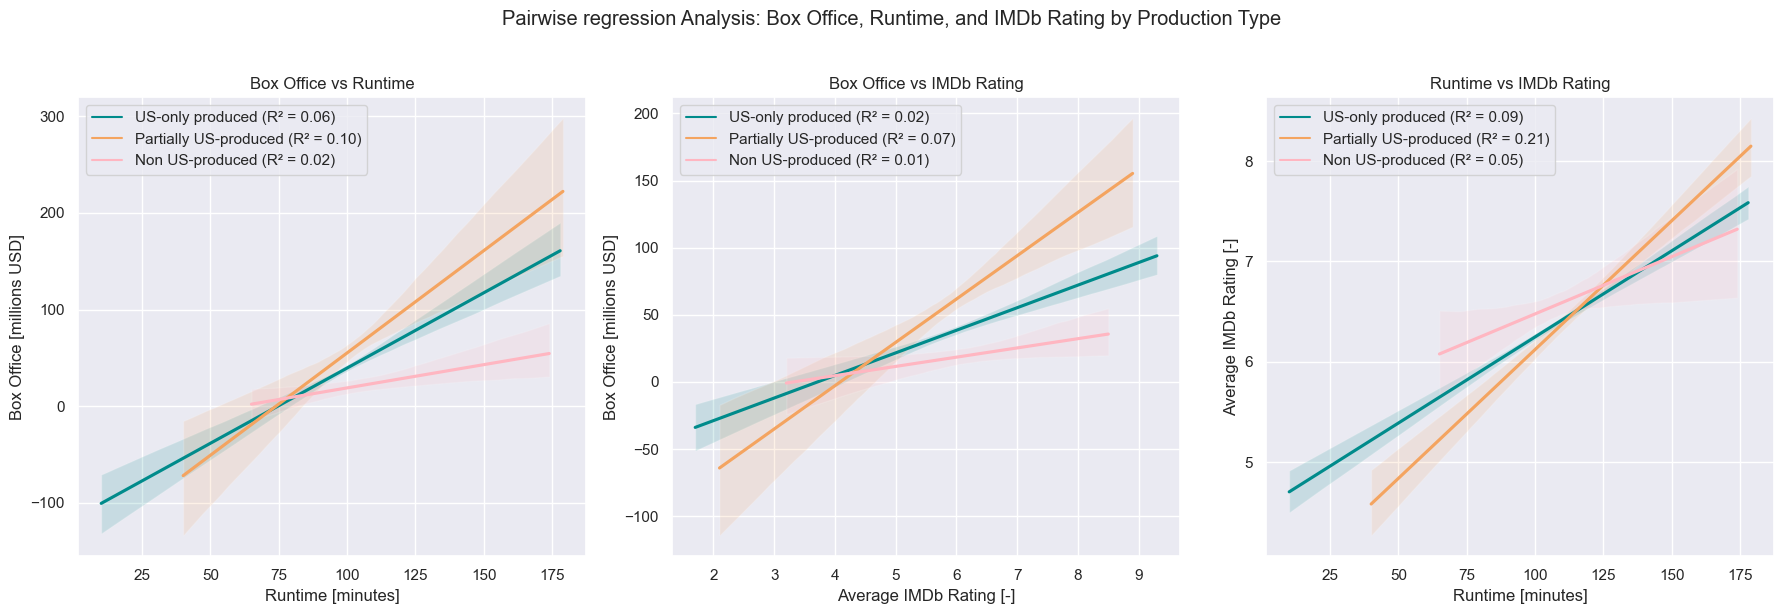

In [28]:
# Select only relevant columns for analysis, add a 'production_type' column and remove the NaN values
us_movies_subset = us_movies[['box_office', 'runtime', 'averageRating']].dropna(subset=['box_office', 'runtime', 'averageRating']).copy()
us_movies_subset['production_type'] = 'US-only produced'

us_partially_movies_subset = us_partially_movies[['box_office', 'runtime', 'averageRating']].dropna(subset=['box_office', 'runtime', 'averageRating']).copy()
us_partially_movies_subset['production_type'] = 'Partially US-produced'

rest_world_non_US_subset = rest_world_non_US[['box_office', 'runtime', 'averageRating']].dropna(subset=['box_office', 'runtime', 'averageRating']).copy()
rest_world_non_US_subset['production_type'] = 'Non US-produced'

# Scale box office values to millions for better readability
us_movies_subset['box_office'] = us_movies_subset['box_office'] / 1e6
us_partially_movies_subset['box_office'] = us_partially_movies_subset['box_office'] / 1e6
rest_world_non_US_subset['box_office'] = rest_world_non_US_subset['box_office'] / 1e6

# Combine the subsets
combined_df = pd.concat([us_movies_subset, us_partially_movies_subset, rest_world_non_US_subset], ignore_index=True)

# Rename the columns of the new df to have clearer axes
combined_df = combined_df.rename(columns={
    'box_office': 'Box Office [millions USD]',
    'averageRating': 'Average IMDb Rating [-]',
    'runtime': 'Runtime [minutes]'
})

# Filter out movies with runtime > 180 minutes once again
combined_df = combined_df[combined_df['Runtime [minutes]'] <= 180].copy()

# Calculate R^2 and plot regression lines with labels
def plot_reg_with_r2(data, x, y, ax, color, label):
    # Fit a linear model to calculate R^2
    model = LinearRegression()
    x_values = data[x].values.reshape(-1, 1)
    y_values = data[y].values
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    r2 = r2_score(y_values, y_pred)
    
    # Using sns.regplot for teh regression line
    sns.regplot(x=x, y=y, data=data, ax=ax, color=color, scatter=False)
    
    # Add label for the regression line with R^2 value
    ax.plot([], [], color=color, label=f"{label} (R² = {r2:.2f})")
    ax.legend()

# creating the figure containing the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = {'US-only produced': 'darkcyan', 'Partially US-produced': 'sandybrown', 'Non US-produced': 'lightpink'}

# Plot each category with regplot and R^2 annotations
for production_type, color in colors.items():
    subset = combined_df[combined_df['production_type'] == production_type]
    
    # Box Office vs Runtime
    plot_reg_with_r2(subset, 'Runtime [minutes]', 'Box Office [millions USD]', axs[0], color, production_type)
    axs[0].set_title('Box Office vs Runtime')
    
    # Box Office vs IMDb Rating
    plot_reg_with_r2(subset, 'Average IMDb Rating [-]', 'Box Office [millions USD]', axs[1], color, production_type)
    axs[1].set_title('Box Office vs IMDb Rating')
    
    # Runtime vs IMDb Rating
    plot_reg_with_r2(subset, 'Runtime [minutes]', 'Average IMDb Rating [-]', axs[2], color, production_type)
    axs[2].set_title('Runtime vs IMDb Rating')

# Main title and layout adjustments
fig.suptitle("Pairwise regression Analysis: Box Office, Runtime, and IMDb Rating by Production Type", y=1.02)
plt.tight_layout()
plt.show()

The above figure provides a pairwise regression analysis between box office, runtime, and average IMDb ratings by Production Type.
<br>
First one looks at the box office vs the runtime : one observes that fitting a simple regression line gives very low $R^2$ for all production types. This can be due to several factors: first the relationship between box office and IMDb ratings might be polynomial or non linear. Then, it can be that there is no link between box office revenue and runtime. <br>
All the plots show the same behaviour.
<br>
**To conclude, the following plots are not sufficient to provide clear insights about if the US-only and partially US-produced movies lead to better ratings when compared with box office revenue and runtime. One will thus implement polynomial regression in the below cell to explore this hypothesis as well as statistical test in the below cells to investigate further.**

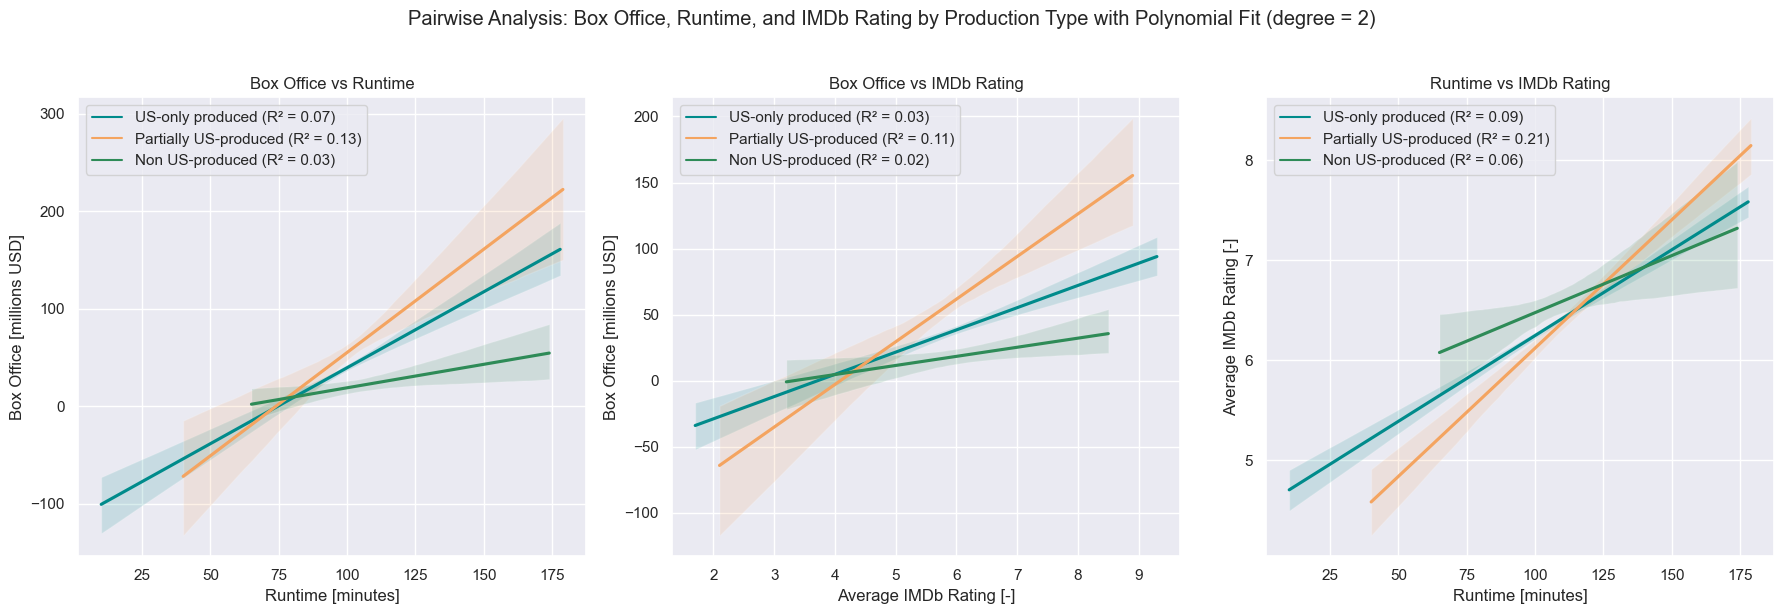

In [29]:
# Function to calculate R^2 and plot polynomial regression with labels
def plot_poly_reg_with_r2(data, x, y, ax, color, label, degree=2):
    # Fit a polynomial model
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(data[x].values.reshape(-1, 1))
    model = LinearRegression()
    model.fit(x_poly, data[y].values)
    y_pred = model.predict(x_poly)
    r2 = r2_score(data[y].values, y_pred)
    
    # Plot with sns.regplot, disable scatter and use color for line
    sns.regplot(x=x, y=y, data=data, ax=ax, color=color, scatter=False)
    # Add label for the regression line with R^2 value
    ax.plot([], [], color=color, label=f"{label} (R² = {r2:.2f})")
    ax.legend()


# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = {'US-only produced': 'darkcyan', 'Partially US-produced': 'sandybrown', 'Non US-produced': 'seagreen'}

# Plot each category with polynomial regression (degree=2) and R^2 annotations
for production_type, color in colors.items():
    subset = combined_df[combined_df['production_type'] == production_type]
    
    # Box Office vs Runtime
    plot_poly_reg_with_r2(subset, 'Runtime [minutes]', 'Box Office [millions USD]', axs[0], color, production_type, degree=2)
    axs[0].set_title('Box Office vs Runtime')
    
    # Box Office vs IMDb Rating
    plot_poly_reg_with_r2(subset, 'Average IMDb Rating [-]', 'Box Office [millions USD]', axs[1], color, production_type, degree=2)
    axs[1].set_title('Box Office vs IMDb Rating')
    
    # Runtime vs IMDb Rating
    plot_poly_reg_with_r2(subset, 'Runtime [minutes]', 'Average IMDb Rating [-]', axs[2], color, production_type, degree=2)
    axs[2].set_title('Runtime vs IMDb Rating')

# Main title and layout adjustments
fig.suptitle("Pairwise Analysis: Box Office, Runtime, and IMDb Rating by Production Type with Polynomial Fit (degree = 2)", y=1.02)
plt.tight_layout()
plt.show()


The $R^2$ values do not change much even though they slightly increased, so a quadratic relationship does not seem to capture the link between box office revenue, IMDb ratings and runtime.

Statistical test

In [30]:
# Hypothesis stating
# H0: null hypothesis: there is NO significant link between the two variables of interest, namely bewteen box_office and IMDB ratings, runtime and IMDb rating & box vs runtime
# HA: alternative hypothesis: there is a significant link between the two variables of interest, namely bewteen box_office and IMDB ratings, runtime and IMDb rating & box vs runtime

ALPHA = 0.05 # significance level for the statistical tests

df_production_list = [us_movies, us_partially_movies, rest_world_non_US]
names_list = ["US-only produced", "US partially produced", "Non-US produced"]
list_spearman_production_box_IMDB = []
list_spearman_production_runtime_IMDB = []
list_spearman_production_box_runtime = []
for df in df_production_list:
    # spearman r correlation coeff chosen since box office distribution is not normal but heavy-tailed and because all values are continuous.
    result_box_IMDB = spearmanr(df['box_office'],df['averageRating'], nan_policy='omit')
    result_runtime_IMDB = spearmanr(df['runtime'],df['averageRating'], nan_policy='omit') 
    result_box_runtime = spearmanr(df['box_office'],df['runtime'], nan_policy='omit')
    list_spearman_production_box_IMDB.append(result_box_IMDB)
    list_spearman_production_runtime_IMDB.append(result_runtime_IMDB)
    list_spearman_production_box_runtime.append(result_box_runtime)

# Correlation investigation between box office revenue & average IMDb rating
for name, stat_result in zip(names_list, list_spearman_production_box_IMDB):
    if stat_result[1] < ALPHA:
        print(f"The spearman correlation coefficient is {stat_result[0]:.2f}.")
        print(f"The is a significant link between box office revenue and average IMDb ratings for {name} movies. We can confidently reject the null Hypothesis H0 ({stat_result[1]:.2e} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"The spearman correlation coefficeient is {stat_result[0]:.2f}.")
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between box office revenue and average IMDb ratings for {name} movies ({stat_result[1]:.2e} > {ALPHA}).")
print("\n") # to improve readability

# Correlation investigation between runtime & average IMDb rating
for name, stat_result in zip(names_list, list_spearman_production_runtime_IMDB):
    if stat_result[1] < ALPHA:
        print(f"The spearman correlation coefficient is {stat_result[0]:.2f}.")
        print(f"The is a significant link between runtime and average IMDb ratings for {name} movies. We can confidently reject the null Hypothesis H0 ({stat_result[1]:.2e} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"The spearman correlation coefficient is {stat_result[0]:.2f}.")
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between runtime and average IMDb ratings for {name} movies ({stat_result[1]:.2e} > {ALPHA}).")
print("\n") 

# Correlation investigation between box office revenue & runtime
for name, stat_result in zip(names_list, list_spearman_production_box_runtime):
    if stat_result[1] < ALPHA:
        print(f"The spearman correlation coefficient is {stat_result[0]:.2f}.")
        print(f"The is a significant link between box office revenue and runtime for {name} movies. We can confidently reject the null Hypothesis H0 ({stat_result[1]:.2e} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"The spearman correlation coefficient is {stat_result[0]:.2f}.")
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between box office revenue and runtime for {name} movies ({stat_result[1]:.2e} > {ALPHA}).")

The spearman correlation coefficient is 0.15.
The is a significant link between box office revenue and average IMDb ratings for US-only produced movies. We can confidently reject the null Hypothesis H0 (1.89e-16 < 0.05).
The spearman correlation coefficient is 0.21.
The is a significant link between box office revenue and average IMDb ratings for US partially produced movies. We can confidently reject the null Hypothesis H0 (1.74e-07 < 0.05).
The spearman correlation coefficient is 0.23.
The is a significant link between box office revenue and average IMDb ratings for Non-US produced movies. We can confidently reject the null Hypothesis H0 (4.32e-04 < 0.05).


The spearman correlation coefficient is 0.30.
The is a significant link between runtime and average IMDb ratings for US-only produced movies. We can confidently reject the null Hypothesis H0 (2.94e-61 < 0.05).
The spearman correlation coefficient is 0.47.
The is a significant link between runtime and average IMDb ratings for US p

One can reject the null hypothesis for all pairwise combinations. Furthermore, the correlation coefficients are not that low which contradicts the pairwise regression and second order polynomial analysis done earlier. However, the spearman test is well suited to capture non-linear relationships and thus might give more reliable results since the correlation seems to be non-linear.

**Now, let's investigate the translations and the genres together.**

In [31]:
################################# PRELIMINARY PROCESSING ################################################
    
#the column of genre can contain many genres, to do so we explode the dataset according to the genres
movies_mtd_genre_exploded=movie_mtd.copy()
movies_mtd_genre_exploded['genres_IMDB'] = movies_mtd_genre_exploded['genres_IMDB'].str.split(',') #creates a list with the genres

#we create a row for each genre, so each movie genre is duplicated to have one genre/row
movies_mtd_genre_exploded = movies_mtd_genre_exploded.explode('genres_IMDB')
#reset index to avoid problems latter with the groupby
movies_mtd_genre_exploded = movies_mtd_genre_exploded.reset_index(drop=True)

#count the number of traductions for each genre among all movies
#each comma separates 2 languages, so the number of languages is the number of comma +1, the number of translations is the number of comma
#auxiliary function
def language_count(x):
    if isinstance(x, str):
        return  x.count(',')     
    else :
        return False
    
movies_mtd_genre_exploded['translations_count']=movies_mtd_genre_exploded['languages'].apply(lambda x: language_count(x))

######################## Isolate us movies from this dataset ##################

#strictly aericain movies
movies_mtd_strict_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].apply(lambda x: x.lower()=='united states of america' if isinstance(x, str) else False)]
#movies produced by US but not only
movies_mtd_incl_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].str.contains('United States of America', na=False) & movie_mtd['countries'].str.contains(',', na=False)]

Which genre is cumulating the most traductions among US genres ?


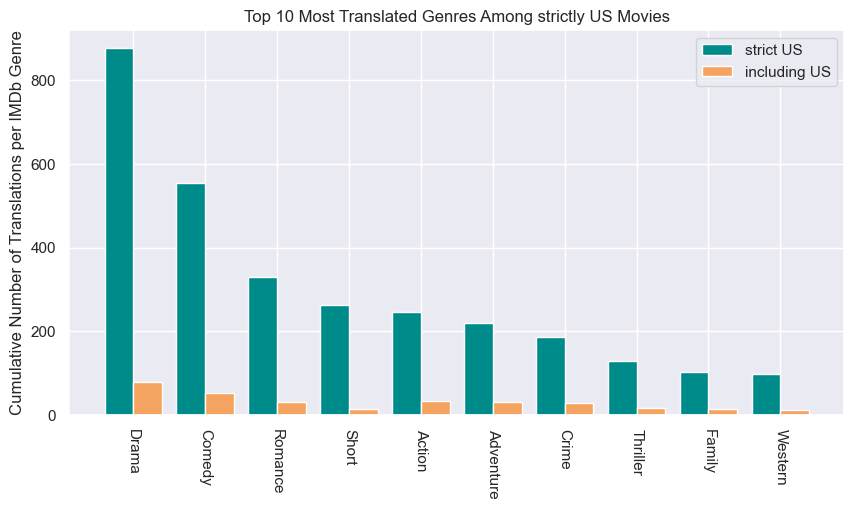

In [32]:
#among US movies, we'll calculate the number of translations for each movie and then use a groubpy on the genres and sum up the the number of translations

groupby_genre_translation_strict_us=movies_mtd_strict_us_genre_exploded['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['genres_IMDB']).sum()
groupby_genre_translation_incl_us=movies_mtd_incl_us_genre_exploded['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['genres_IMDB']).sum()

#parameters
width = 0.4
n=10

#top 10 genres for movies strictly produced by US
top_genres_strict_us = groupby_genre_translation_strict_us.sort_values(ascending=False).head(n)
#we want to reorder the genres of movies partially produced by the US to match that previous top 10 genres (of movies strictly produced by US)
#to do so, we reindex 
corresponding_genres_incl_us = groupby_genre_translation_incl_us.reindex(top_genres_strict_us.index)

######################################## Plotting ######################################
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bars side by side
ax.bar(np.arange(n) - width/2, top_genres_strict_us, width=width, label='strict US', color='darkcyan')
ax.bar(np.arange(n) + width/2, corresponding_genres_incl_us, width=width, label='including US', color='sandybrown')

# Add labels and titles
ax.legend()
ax.set_title('Top 10 Most Translated Genres Among strictly US Movies')
ax.set_ylabel('Cumulative Number of Translations per IMDb Genre')
ax.set_xticks(np.arange(n))
ax.set_xticklabels(groupby_genre_translation_strict_us.sort_values(ascending=False).head(n).index,rotation=-90)


plt.show()

The genre DRAMA is cumulating the most translations among US movies by far. Regarding the partially US-produced movies, the cumulated translations by genre does not follow exactly the same trend, even though the 3 most translated genres are the same for both strictly and partially US-produced movies (the statistics for partially US-produced movies are not displayed).

**If one assumes that translation numbers are related to the export of movies, one can deduce from this plot that US drama movies are by far the most exported genre worldwide and thus USA could spread their culture through these movies.**

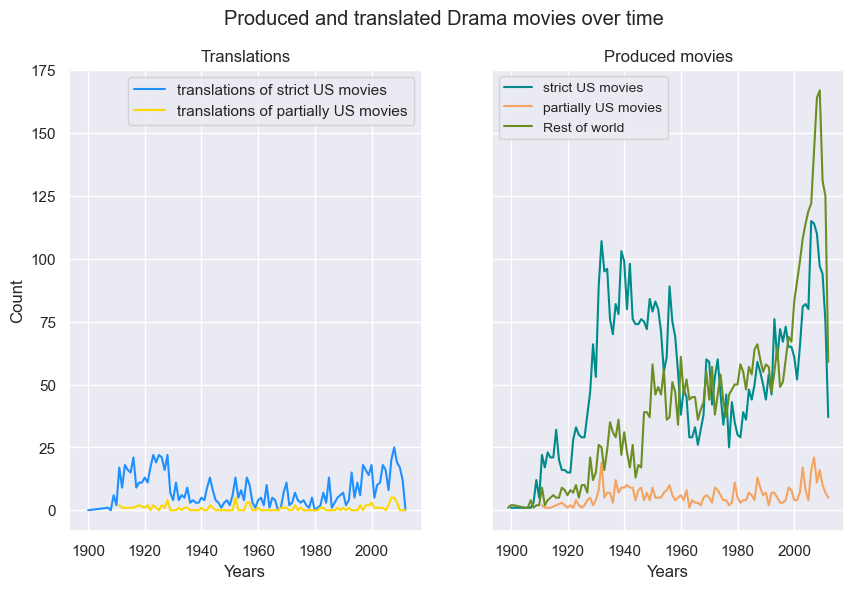

In [33]:
# What is the evolution of top1 (DRAMA movies) translated over time ?

# Movies produced by the rest of the world
movies_mtd_restoftheworld_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].str.contains('United States of America', na=False)==False]

###########################################################################################

# Count number of DRAMA movies produced per year in the world
# .reset_index() to use in the sns.linepolt()
drama_produced_restoftheworld = movies_mtd_restoftheworld_genre_exploded[movies_mtd_restoftheworld_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_restoftheworld_genre_exploded['release_year']).count().reset_index()

# Count number of DRAMA movies produced per year in the US (strict/including)
# .reset_index() to use in the sns.linepolt()
drama_produced_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).count().reset_index()
drama_produced_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).count().reset_index()

#Evolution of translations of US Drama movies (strict/including)
drama_translated_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).sum().reset_index()
drama_translated_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).sum().reset_index()



################################################# PLOT ##################################################
# create two subplots with the shared x and y axes
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
#plt.figure(figsize=(10, 18))

# Plot Number of produced Drama movies in the US & in the World
#use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
sns.lineplot(data=drama_translated_strict_us, x='release_year', y='translations_count', label="translations of strict US movies", color='dodgerblue', ax= axes[0]).set(title="Translations")
sns.lineplot(data=drama_translated_incl_us, x='release_year', y='translations_count', label="translations of partially US movies", color='gold', ax=axes[0]).set(title="Translations")
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Years')

sns.lineplot(data=drama_produced_strict_us, x='release_year', y='wiki_movie_ID', label="strict US movies", color='darkcyan', ax=axes[1]).set(title="Produced movies") 
sns.lineplot(data=drama_produced_incl_us, x='release_year', y='wiki_movie_ID', label="partially US movies", color='sandybrown', ax=axes[1]).set(title="Produced movies") 
sns.lineplot(data=drama_produced_restoftheworld, x='release_year', y='wiki_movie_ID', label='Rest of world', color='olivedrab', ax=axes[1]).set(title="Produced movies") 
axes[1].set_xlabel('Years')



fig.suptitle("Produced and translated Drama movies over time")
plt.legend(loc='upper left', fontsize=10, title_fontsize='12')
plt.show()

Let's have a closer look at the most translated genre among US movies and therefore probably the most exported one: drama movies. 

Between 1920 and 1930, US Drama movies's translations are at their peak, even though the peak of produced US drama movies was not reached yet. Between 1930 and 1940, US are producing alone the great majority of Drama movies, before decreasing until the 70's. Started from the 80's, US Drama movies production and translations increase again, reaching a second peak in the years 2010. Overall the production of movies produced in the rest of the world increased over the considered timespan.

# 2. Character metadata enriched with DBpedia actor's nationality

### 2.1 General information about the dataset

#### 2.1.1 Exploring nationality column

In [34]:
# Datasets and variables used

name_list = ['Foreign','US']

all_movies = actor_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = actor_mtd.copy() 
us_partially_movies = actor_mtd.copy()
all_us_movies = actor_mtd.copy()
rest_world_non_US = actor_mtd.copy()

# movies strictly produced in the us
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]
# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

***************** Nationality proportions *******************
The percentages of American actors in the dataset is : 35.81%
The percentages of Foreign actors in the dataset is : 32.57%
The percentages of NaN values of nationality in the dataset is : 31.62% 

***************** Gender ratio per nationality *******************
The gender ratio of American actors in the dataset is (F/M) : 0.5294
The gender ratio of Foreign actors in the dataset is (F/M): 0.5142

***************** Age distribution per nationality *******************


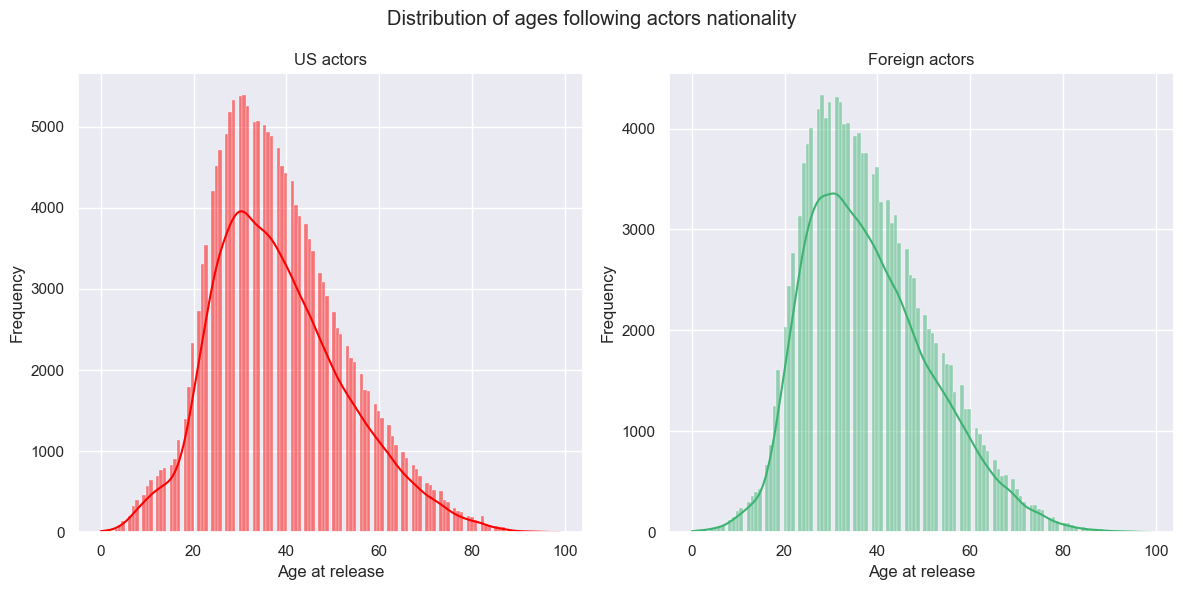

In [35]:
# Exploration of actors nationality - important as we have created this column ourselves
total_us_actors = all_movies.loc[all_movies['nationality'] == 'American']
total_for_actors = all_movies.loc[all_movies['nationality'] == 'Other']

# Nationality proportions 
nat_length = actor_mtd['nationality'].shape[0]
print("***************** Nationality proportions *******************")
print(f"The percentages of American actors in the dataset is : {(total_us_actors['nationality'].count()/nat_length*100):.4g}%")
print(f"The percentages of Foreign actors in the dataset is : {(total_for_actors['nationality'].count()/nat_length*100):.4g}%")
print(f"The percentages of NaN values of nationality in the dataset is : {(actor_mtd['nationality'].isna().sum()/nat_length*100):.4g}% \n")

# Gender proportion
print("***************** Gender ratio per nationality *******************")
print(f"The gender ratio of American actors in the dataset is (F/M) : {(total_us_actors[total_us_actors['gender']=='F']['gender'].count()/total_us_actors[total_us_actors['gender']=='M']['gender'].count()):.4g}")
print(f"The gender ratio of Foreign actors in the dataset is (F/M): {(total_for_actors[total_for_actors['gender']=='F']['gender'].count()/total_for_actors[total_for_actors['gender']=='M']['gender'].count()):.4g}\n")

# Age distribution
print("***************** Age distribution per nationality *******************")
fig, axes = plt.subplots(1, 2, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(total_us_actors['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='red', cumulative = False, log_scale= False, ax=axes[0]).set(title="US actors") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Age at release")
sns.histplot(total_for_actors['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='mediumseagreen', cumulative = False, log_scale= False, ax=axes[1]).set(title="Foreign actors")
axes[1].set_xlabel("Age at release")
fig.suptitle("Distribution of ages following actors nationality") # to avoid any overlapping
fig.tight_layout()
plt.show()

Here, we begin by very simple data exploration, focusing on our main variables of interest (nationality, age, gender).

For the general evaluation of the dataset, we remark a roughly similar proportion of US and non-US actors. This is good for our further analysis because it means the dataset classes US/Foreign are balanced (in proportions at least). On the other hand, this finding shows how America is really ruling the cinematic industry, including actors nationality. Caution here though, as we need to further investigate the link between actors nationality and film production country, i.e. maybe American producers favor American actors, so a large proportion of US movies would then imply more US actors. 

Regarding the proportion of NaN values, around 1/3 of the actors do not have a nationality value. It's not perfect, but we can still use nationality for further analysis.


Grouping by nationality, we want to explore if the US/Foreign actors have different distribution of age and proportion of gender. Those variables will serve for our in-depth study and we need to verify if the distributions/proportions are similar between the two partitions of the dataset. If not, we would need to account for the difference when analysis and drawing conclusions on the data.

Regarding the results with the grouping, we observe similar values for gender ratio and roughly similar distribution of age. Interestingly, the age distribution seems to follow a normal law, slightly right-skewed, - an interesting insight to keep for later.



#### 2.1.2 Exploring actors nationalities in relations to movies origin

***************** American actors *******************
The total number of US actors in the dataset is 161386.
The total number of US actors in american movies uniquely produced in the US in the dataset is : 129040.
The total number of US actors in american movies partially produced in the US in the dataset is : 16602. 

***************** Foreign actors *******************
The total number of foreign actors in the dataset is 146768.
The total number of foreign actors in american movies uniquely produced in the US, in the dataset is : 21464.
The total number of foreign actors in american movies partially produced in the US, in the dataset is : 13173. 

***************** Movie production country following actor's nationality *******************


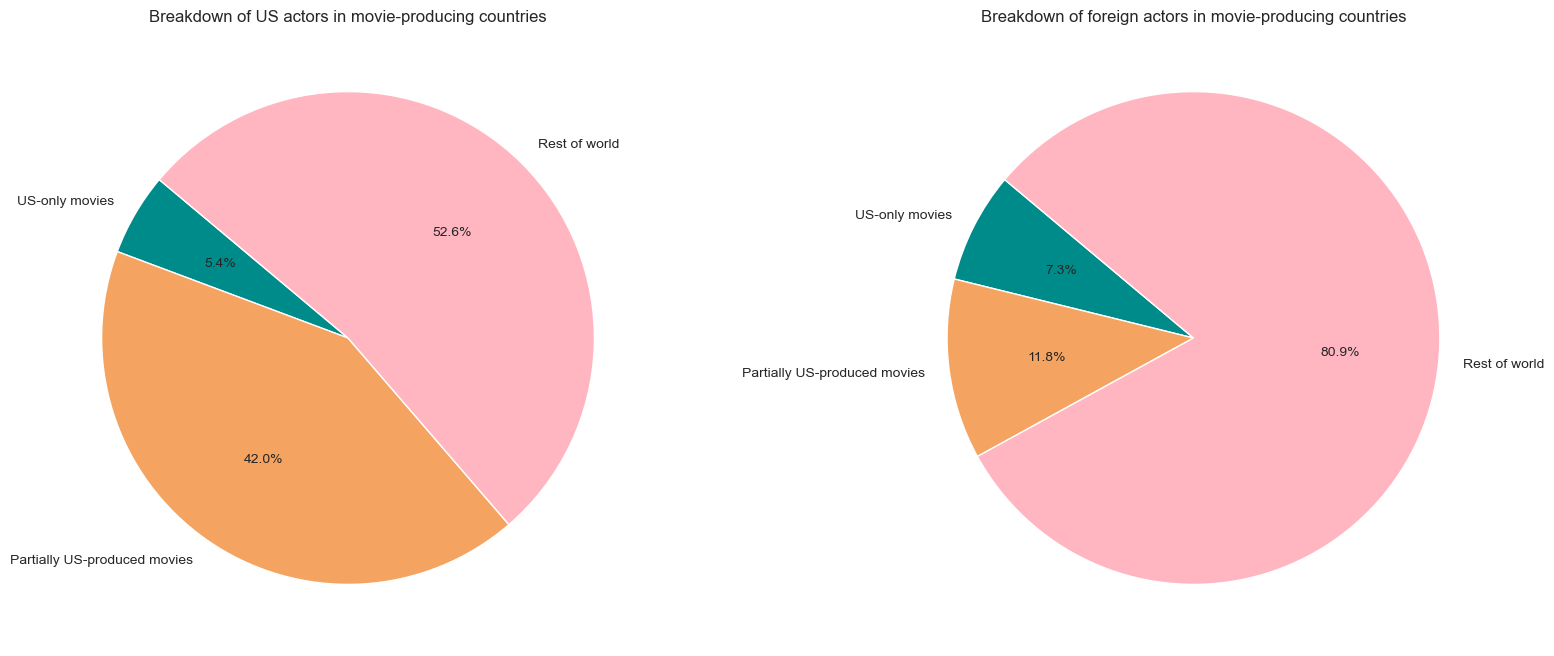

In [36]:
# Exploration of actor nationalities related to movies origin

# US actors in the different group of movies
us_actors_part_us_movies = us_partially_movies.loc[us_partially_movies['nationality'] == 'American']
us_actors_us_movies = us_movies.loc[us_movies['nationality'] == 'American']
us_actors_world_movies = rest_world_non_US.loc[rest_world_non_US['nationality'] == 'American']

print("***************** American actors *******************")
print(f"The total number of US actors in the dataset is {len(total_us_actors)}.")
print(f"The total number of US actors in american movies uniquely produced in the US in the dataset is : {len(us_actors_us_movies)}.")
print(f"The total number of US actors in american movies partially produced in the US in the dataset is : {len(us_actors_part_us_movies)}. \n")

list_us_actors_granular = [ len(us_actors_part_us_movies), len(us_actors_us_movies), len(total_us_actors -(us_actors_us_movies + us_actors_part_us_movies))] 

# Non-US actors in the different group of movies
for_actors_part_us_movies = us_partially_movies.loc[us_partially_movies['nationality'] == 'Other']
for_actors_us_movies = us_movies.loc[us_movies['nationality'] == 'Other']
for_actors_world_movies = rest_world_non_US.loc[rest_world_non_US['nationality'] == 'Other']

print("***************** Foreign actors *******************")
print(f"The total number of foreign actors in the dataset is {len(total_for_actors)}.")
print(f"The total number of foreign actors in american movies uniquely produced in the US, in the dataset is : {len(for_actors_us_movies)}.")
print(f"The total number of foreign actors in american movies partially produced in the US, in the dataset is : {len(for_actors_part_us_movies)}. \n")

list_foreign_actors_granular = [len(for_actors_part_us_movies), len(for_actors_us_movies),  len(total_for_actors -(for_actors_us_movies + for_actors_part_us_movies))] 

print("***************** Movie production country following actor's nationality *******************")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.pie(
    list_us_actors_granular,
    labels= ['US-only movies', 'Partially US-produced movies' , 'Rest of world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
ax1.set_title("Breakdown of US actors in movie-producing countries")

ax2.pie(
    list_foreign_actors_granular,
    labels= ['US-only movies', 'Partially US-produced movies' , 'Rest of world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
ax2.set_title("Breakdown of foreign actors in movie-producing countries")

plt.show()

Going a little bit deeper in the analysis, we explore data proportions, following both actors nationality and films origin.

It will serve to desentangle the links between both variables. We specifically focus on those two variables to assess the influence of the movie origin on an actor's career (and success) and the factors (like actors nationality) that might affect this link.

The outcome is mirroing our expectations for the foreign actors. Indeed, Foreign actors are mostly playing in foreign movies. On the other hand, American actors are playing as much in movies with US origin (including both only US and partially US) as in movies not originating from the US. Interestingly, American actors don't play so much in US-only movies.

As we have roughly the same number of US and Foreign actors, we can say US actors export more to the rest of the world than Foreign actors export to the US, i.e. we have a net flux of actors exporting from the US to the rest of the world - from a movie making perspective.
In a later step, we will also put those figures in relations to the pie chart showing the fraction of movies per origin.

We need to keep in mind that nationality does not mean country of living. So, the fraction foreign actors playing in US movies may just include people actually living in the US and not really "foreigners" called specifically to play in an American movies. This reminder will help us analyse more truthfully the data.

 

#### Box office - basic statistics

***************** Movie revenue distribution per nationality (log transformed data to deal with right skewed tendency) *******************


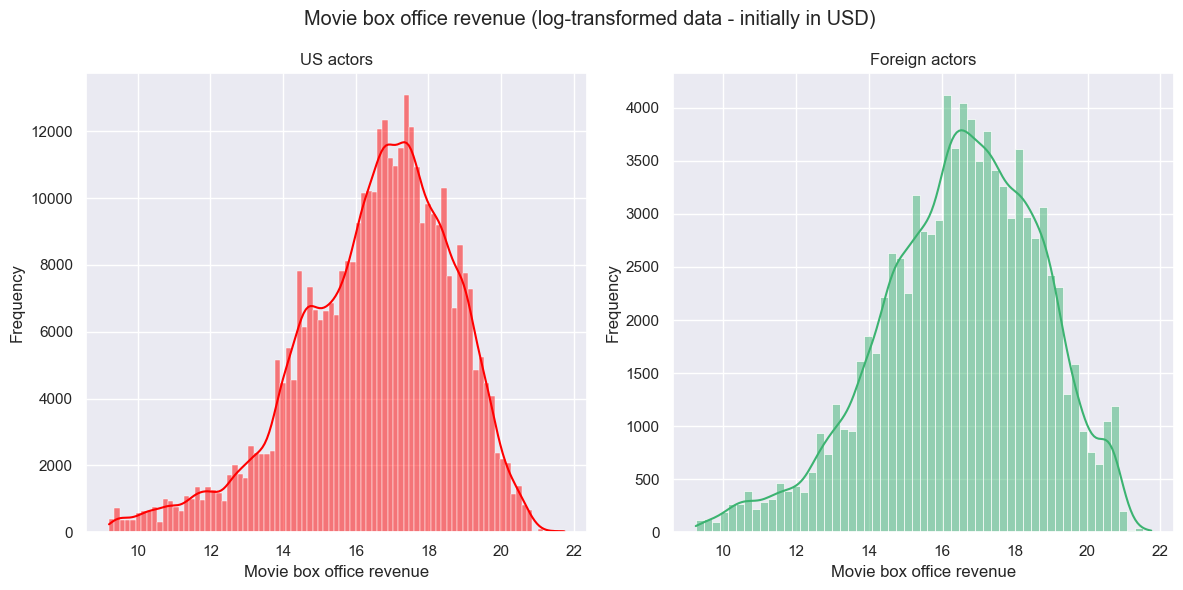

In [37]:
## Study the relationship between nationality and movie box office, folllowing movie origin
print("***************** Movie revenue distribution per nationality (log transformed data to deal with right skewed tendency) *******************")
fig, axes = plt.subplots(1, 2, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
# Log transforme the data because it is right skewed 
sns.histplot(total_us_actors['box_office'].apply(lambda x: np.log(x)), kde=True, stat='frequency', bins = 'auto', color='red', cumulative = False, log_scale= False, ax=axes[0]).set(title="US actors") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Movie box office revenue")
sns.histplot(total_for_actors['box_office'].apply(lambda x: np.log(x)), kde=True, stat='frequency', bins = 'auto', color='mediumseagreen', cumulative = False, log_scale= False, ax=axes[1]).set(title="Foreign actors")
axes[1].set_xlabel("Movie box office revenue")

fig.suptitle("Movie box office revenue (log-transformed data - initially in USD) ") # to avoid any overlapping
fig.tight_layout()
plt.show()

In [38]:
# US actors

# Whole dataset
us_box_office_all_movies = total_us_actors['box_office'].describe()
# US actors in american movies STRICTLY produced in the US
us_box_office_US = us_actors_us_movies['box_office'].describe()
# US actors in american movies PARTIALLY produced in the US
us_box_office_US_partial = us_actors_part_us_movies['box_office'].describe()
# US actors est of world (= Non Us movies)
us_box_office_ROW = us_actors_world_movies['box_office'].describe()

dict_results_us_actors = {'All movies': [us_box_office_all_movies.loc['50%'], us_box_office_all_movies.loc['mean'], us_box_office_all_movies.loc['std'], us_box_office_all_movies.loc['max'], us_box_office_all_movies.loc['min']], 
                'US-only produced': [us_box_office_US.loc['50%'], us_box_office_US.loc['mean'], us_box_office_US.loc['std'], us_box_office_US.loc['max'],us_box_office_US.loc['min']], 
                'Partially US-produced': [us_box_office_US_partial.loc['50%'], us_box_office_US_partial.loc['mean'], us_box_office_US_partial.loc['std'], us_box_office_US_partial.loc['max'], us_box_office_all_movies.loc['min']],
                'Non US produced (ROW)': [us_box_office_ROW.loc['50%'], us_box_office_ROW.loc['mean'], us_box_office_ROW.loc['std'], us_box_office_ROW.loc['max'], us_box_office_ROW.loc['min']]}

df_us_box_office = pd.DataFrame(dict_results_us_actors, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6

In [39]:
# Foreign actors

# Whole dataset
for_box_office_all_movies = total_for_actors['box_office'].describe()
# US actors in american movies STRICTLY produced in the US
for_box_office_US = for_actors_us_movies['box_office'].describe()
# US actors in american movies PARTIALLY produced in the US
for_box_office_US_partial = for_actors_part_us_movies['box_office'].describe()
# US actors est of world (= Non Us movies)
for_box_office_ROW = for_actors_world_movies['box_office'].describe()

dict_results_for_actors = {'All movies': [for_box_office_all_movies.loc['50%'], for_box_office_all_movies.loc['mean'], for_box_office_all_movies.loc['std'], for_box_office_all_movies.loc['max'], for_box_office_all_movies.loc['min']], 
                'US-only produced': [for_box_office_US.loc['50%'], for_box_office_US.loc['mean'], us_box_office_US.loc['std'], for_box_office_US.loc['max'],for_box_office_US.loc['min']], 
                'Partially US-produced': [for_box_office_US_partial.loc['50%'], for_box_office_US_partial.loc['mean'], for_box_office_US_partial.loc['std'], for_box_office_US_partial.loc['max'], for_box_office_all_movies.loc['min']],
                'Non US produced (ROW)': [for_box_office_ROW.loc['50%'], for_box_office_ROW.loc['mean'], for_box_office_ROW.loc['std'], for_box_office_ROW.loc['max'], for_box_office_ROW.loc['min']]}

df_for_box_office = pd.DataFrame(dict_results_for_actors, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6

In [40]:
print("***************** Movie revenue distribution per nationality *******************")
# Display both tables at the same time for easier comparison (from the results of the 2 above cells)
df_us_box_office.columns = pd.MultiIndex.from_tuples([("American Actors", col) for col in df_us_box_office.columns])
df_for_box_office.columns = pd.MultiIndex.from_tuples([("Foreign Actors", col) for col in df_for_box_office.columns])

# Concatenate the DataFrames along the columns with hierarchical indexing
df_combined_box_office = pd.concat([df_us_box_office, df_for_box_office], axis=1)

# Show only 2 decimals
df_combined_box_office.style.format("{:.2f}")

***************** Movie revenue distribution per nationality *******************


In a second time, we investigated the type of movies (high box office or not) American v/s Foreign actors were playing in. Those tables play a role in our analysis of actors' career success per nationality. Specifically, we want to see if Foreign actors typically play in movies with higher box office revenue (that we can consider as "successful" - though we'll derive later a more precise index for that) than American ones. This is a first insight to verify our hypothesis that playing in American films boosts an actors' career, so foreigner are tempted to act in the US, feeding this dominance loop of American cinema.

First, we see that the movie box office revenue is right skewed for both types of actors nationality - this is also the case when considering all actors. After log-transforming the values, we see a roughly normal distribution (slightly left-skewed), so movie box office revenue is log-normally distributed. While the distributions for the different nationalities are not identical (the Foreigner distribution is slightly wider), we can still assume that American vs Foreign box office variables are comparable. 

When looking at the tables then, we focus our comparison on the median, for the data is right skewed. For both Foreign & American actors, it seems playing in American movies (either partially or only US produced) is synonymous of higher median box office revenue, compared with rest of the world origin. Also, it seems actors playing in movies of a different origin than theirs (that is, American actors playing in rest of the world movies and vice versa) are associated with higher median box office revenues. Finally, movies co-produced by the US have, for both nationalities, the highest revenues among all film origins. But for co-produced films, American actors seem to play in movies with higher box offices (so "more successful" movies) than foreign actors.

We will try to get explanations for those figures later in the study.

#### Age at movie release - basic statistics

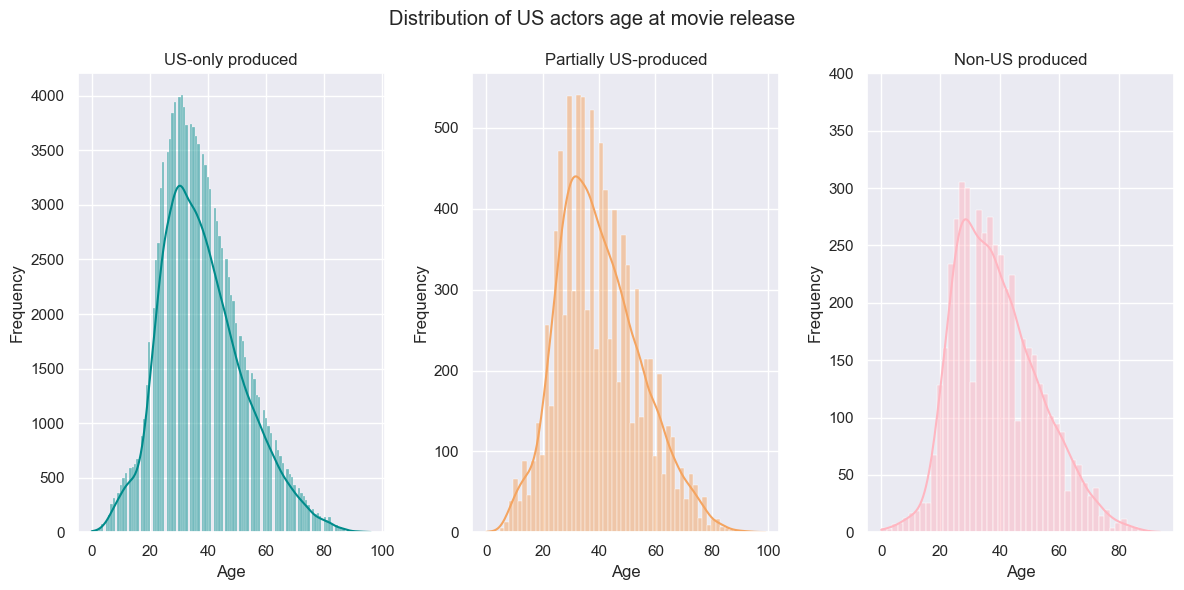

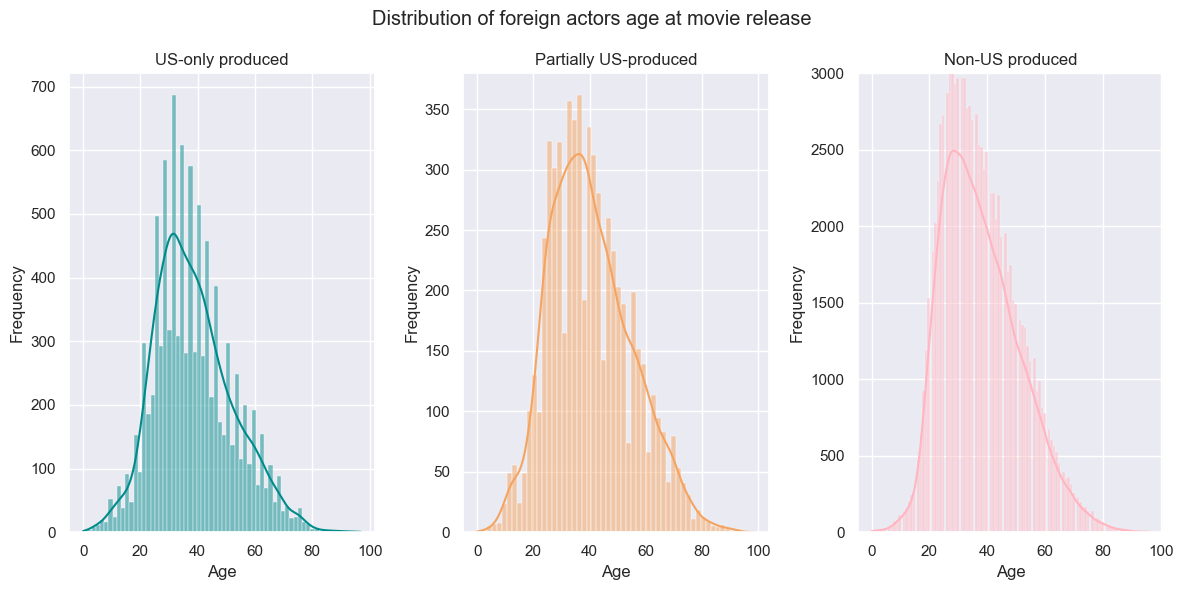

In [41]:
# First visualization of the distribution of age at movie release

# US actors
fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_actors_us_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Age")
sns.histplot(us_actors_part_us_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Age")
sns.histplot(us_actors_world_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='lightpink', cumulative = False, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Age")
fig.suptitle("Distribution of US actors age at movie release") # to avoid any overlapping
plt.ylim(0, 400)
fig.tight_layout()
plt.show()

# Foreign actors
fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(for_actors_us_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Age")
sns.histplot(for_actors_part_us_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Age")
sns.histplot(for_actors_world_movies['age_at_release'], kde=True, stat='frequency', bins = 'auto', color='lightpink', cumulative = False, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Age")
fig.suptitle("Distribution of foreign actors age at movie release") # to avoid any overlapping
plt.ylim(0, 3000)
fig.tight_layout()
plt.show()

In [42]:
# US actors

# Whole dataset
us_age_all_movies = total_us_actors['age_at_release'].describe()
# US actors in american movies STRICTLY produced in the US
us_age_US = us_actors_us_movies['age_at_release'].describe()
# US actors in american movies PARTIALLY produced in the US
us_age_US_partial = us_actors_part_us_movies['age_at_release'].describe()
# US actors est of world (= Non Us movies)
us_age_ROW = us_actors_world_movies['age_at_release'].describe()

dict_results_us_actors = {'All movies': [us_age_all_movies.loc['50%'], us_age_all_movies.loc['mean'], us_age_all_movies.loc['std'], us_age_all_movies.loc['max'], us_age_all_movies.loc['min']], 
                'US-only produced': [us_age_US.loc['50%'], us_age_US.loc['mean'], us_age_US.loc['std'], us_age_US.loc['max'],us_age_US.loc['min']], 
                'Partially US-produced': [us_age_US_partial.loc['50%'], us_age_US_partial.loc['mean'], us_age_US_partial.loc['std'], us_age_US_partial.loc['max'], us_age_all_movies.loc['min']],
                'Non US produced (ROW)': [us_age_ROW.loc['50%'], us_age_ROW.loc['mean'], us_age_ROW.loc['std'], us_age_ROW.loc['max'], us_age_ROW.loc['min']]}

df_us_age = pd.DataFrame(dict_results_us_actors, index = ['median', 'mean', 'std', 'max', 'min']) 

In [43]:
# foreign actors

# Whole dataset
for_age_all_movies = total_for_actors['age_at_release'].describe()
# US actors in american movies STRICTLY produced in the US
for_age_US = for_actors_us_movies['age_at_release'].describe()
# US actors in american movies PARTIALLY produced in the US
for_age_US_partial = for_actors_part_us_movies['age_at_release'].describe()
# US actors est of world (= Non Us movies)
for_age_ROW = for_actors_world_movies['age_at_release'].describe()

dict_results_for_actors = {'All movies': [for_age_all_movies.loc['50%'], for_age_all_movies.loc['mean'], for_age_all_movies.loc['std'], for_age_all_movies.loc['max'], for_age_all_movies.loc['min']], 
                'US-only produced': [for_age_US.loc['50%'], for_age_US.loc['mean'], for_age_US.loc['std'], for_age_US.loc['max'],for_age_US.loc['min']], 
                'Partially US-produced': [for_age_US_partial.loc['50%'], for_age_US_partial.loc['mean'], for_age_US_partial.loc['std'], for_age_US_partial.loc['max'], for_age_all_movies.loc['min']],
                'Non US produced (ROW)': [for_age_ROW.loc['50%'], for_age_ROW.loc['mean'], for_age_ROW.loc['std'], for_age_ROW.loc['max'], for_age_ROW.loc['min']]}

df_for_age = pd.DataFrame(dict_results_for_actors, index = ['median', 'mean', 'std', 'max', 'min'])

In [44]:
print("***************** Age statistics per nationality *******************")
# Display both tables at the same time for easier comparison
df_us_age.columns = pd.MultiIndex.from_tuples([("American Actors", col) for col in df_us_age.columns])
df_for_age.columns = pd.MultiIndex.from_tuples([("Foreign Actors", col) for col in df_for_age.columns])

# Concatenate the DataFrames along the columns with hierarchical indexing
df_combined_age = pd.concat([df_us_age, df_for_age], axis=1)

# Show only two decimals
df_combined_age.style.format("{:.2f}")

***************** Age statistics per nationality *******************


Here, we investigate the actors age depending on their nationality. It will help us get insights about the stereotypical actors casted for different movie orgins and about the career stage of actors following their nationality and the movie origin they play in.

First, we observe roughly normal distributions of ages, no matter the actor nationality or the movie origin - it mimicks the general age distribution. 

As the data follow a normal law, we can use the usual metrics for interpretations. And overall, the metrics confirm that we have very similar age distributions following the actors nationalities (similar mean, median, std, max, min for both nationalities). Then, US actors are generally younger if casted in US movies (and more young as the film is only produced in the US). That's not true for Foreign actors, that are on average younger in non-US produced movies. Finally, the standard deviation around 14/15 years (for all) suggests are career range of around 30 years - an insight that we could use later for the actors' career assessment.

#### Gender - basic statistics

Text(0.5, 0.98, 'Gender distribution of actors (in %)')

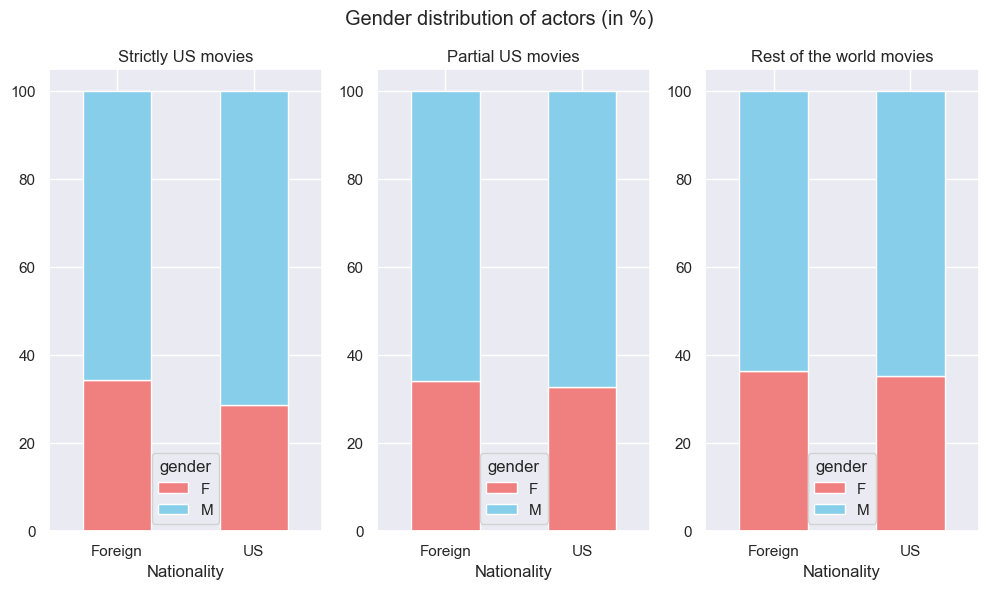

In [45]:
fig, axes = plt.subplots(1, 3, figsize = (12,6))

# Strictly US movies
gender_counts_us = us_movies.groupby(['nationality', 'gender']).size().unstack(fill_value=0)
gender_percentages_us = gender_counts_us.div(gender_counts_us.sum(axis=1), axis=0) * 100
gender_percentages_us.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], ax=axes[0])
axes[0].set_xlabel('Nationality')
axes[0].set_title('Strictly US movies')
axes[0].set_xticklabels(name_list, rotation = 0)

# Partially US movies 
gender_counts_us_partial = us_partially_movies.groupby(['nationality', 'gender']).size().unstack(fill_value=0)
gender_percentages_us_partial = gender_counts_us_partial.div(gender_counts_us_partial.sum(axis=1), axis=0) * 100
gender_percentages_us_partial.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], ax=axes[1])
axes[1].set_xlabel('Nationality')
axes[1].set_title('Partial US movies')
axes[1].set_xticklabels(name_list, rotation = 0)

# Rest of the world's movies
gender_counts_world = rest_world_non_US.groupby(['nationality', 'gender']).size().unstack(fill_value=0)
gender_percentages_world = gender_counts_world.div(gender_counts_world.sum(axis=1), axis=0) * 100
gender_percentages_world.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], ax=axes[2])
axes[2].set_xlabel('Nationality')
axes[2].set_title('Rest of the world movies')
axes[2].set_xticklabels(name_list, rotation = 0)

fig.suptitle('Gender distribution of actors (in %)')

The analysis of gender distribution among U.S. and foreign actors reveals that the pattern is similar across all three movie origin groups. Specifically, female actors represent approximately 30%, while male actors account for around 60%. Interestingly, the gender imbalance is more pronounced in strictly U.S. movies, particularly for U.S. actors compared to foreign actors.

For further analysis, it would be valuable to explore this imbalance in greater depth. For instance, examining the gender distribution across different movie genres could provide insights into the origins of this disparity and why movies depict a world with more men than women. Additionally, analyzing gender distribution over time could reveal whether the imbalance is a legacy of films from earlier eras or a consistent trend in the movie industry. Connecting the gender question with movies containing an American history movie plot might indicate further, if this imbalance has a relationship with american movies and is spread over the world by american movies.

age_group     category
gender          object
box_office     float64
dtype: object


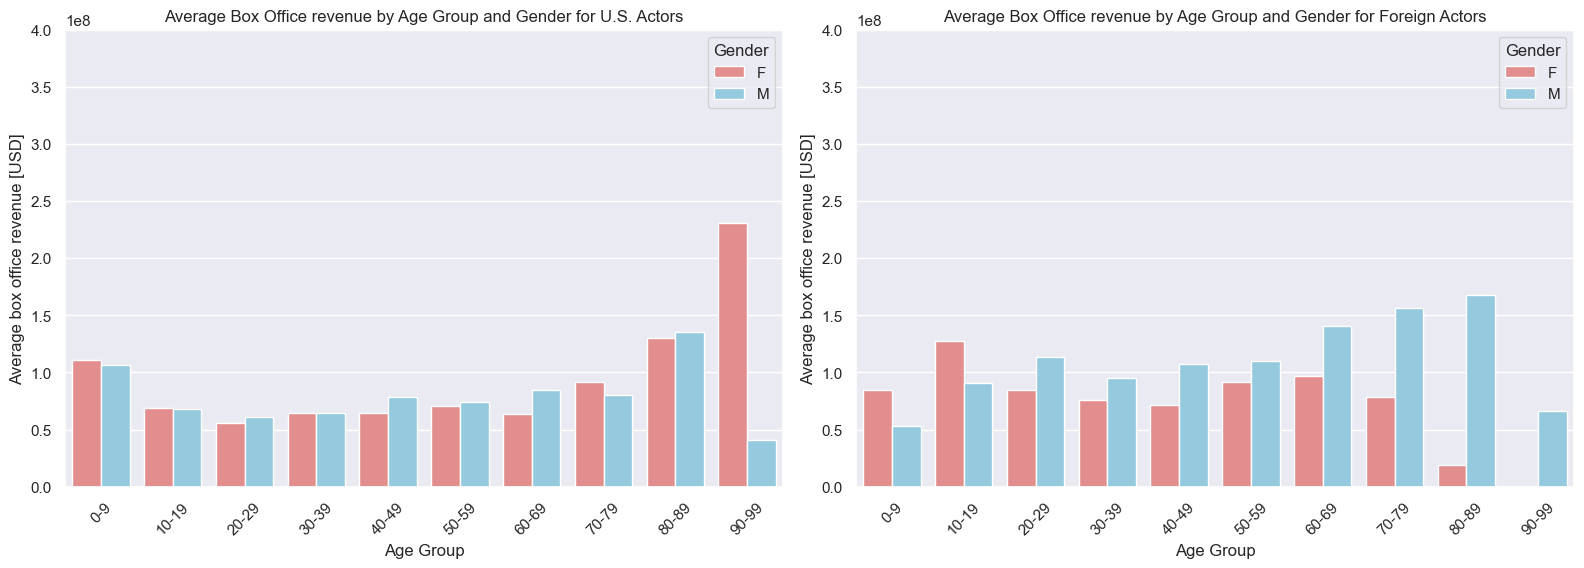

In [46]:
# Focus on strictly US movies
# See if during th eyears there was a change in box office revenue in the 2 groups

# Create age groups
bins = range(0, 101, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Create labels for bins
us_actors_us_movies['age_group'] = pd.cut(us_actors_us_movies['age_at_release'], bins=bins, labels=labels, right=False)
for_actors_us_movies['age_group'] = pd.cut(for_actors_us_movies['age_at_release'], bins=bins, labels=labels, right=False)

us_revenue_by_age_gend = us_actors_us_movies.groupby(['age_group', 'gender'])['box_office'].mean().reset_index()
foreign_revenue_by_age_gend = for_actors_us_movies.groupby(['age_group', 'gender'])['box_office'].mean().reset_index()

print(us_revenue_by_age_gend.dtypes)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting for U.S. Actors
sns.barplot(data=us_revenue_by_age_gend, x='age_group', y = 'box_office', hue='gender', palette=['lightcoral', 'skyblue'], ax=axes[0])
axes[0].set_title('Average Box Office revenue by Age Group and Gender for U.S. Actors')
axes[0].set_xlabel('Age Group')
axes[0].set_ylim(0,4.0*1e8)
axes[0].set_ylabel('Average box office revenue [USD]')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Gender')

# Plotting for Foreign Actors
sns.barplot(data=foreign_revenue_by_age_gend, x='age_group', y='box_office', hue='gender', palette=['lightcoral', 'skyblue'], ax=axes[1])
axes[1].set_title('Average Box Office revenue by Age Group and Gender for Foreign Actors')
axes[1].set_xlabel('Age Group')
axes[1].set_ylim(0,4.0*1e8)
axes[1].set_ylabel('Average box office revenue [USD]')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Gender')

# Adjust layout
plt.tight_layout()
plt.show()

Following our exploration of US/Foreign actors datasets, we delved into gender representation. We had calculated previously gender ratios, but we now use age series and movie origin distinctions.

Regarding the age series, we observe Foreign actresses are casted in movies with lower box office revenue after 20 years old, compared to men. The tendency is not monotonical for American actors, with men playing in higher revenue films only between 10 to 69 years old.

For both nationalities, we see very high revenues for the oldest actors, anomalies that might come from the low number of old actors - that are usually very good actors (keeping actors because asked for), playing in high revenue films.

### 2.2 Exploratory analysis of the dataset according to our research questions

#### Is it easier to have an early career being American and does it help to kick off the actors’ career?

In [47]:
# We create a new dataframe with additional information only about individual actors

df_actors = all_movies[['actor_name', 'birth_date', 'gender', 'height', 'nationality']].drop_duplicates(subset='actor_name').reset_index()

min_age = all_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
min_age.rename(columns={'age_at_release': 'age_first_movie'}, inplace=True)
df_actors = df_actors.merge(min_age, on='actor_name', how='left')

max_age = all_movies.groupby('actor_name', as_index=False)['age_at_release'].max()
max_age.rename(columns={'age_at_release': 'age_last_movie'}, inplace=True)
df_actors = df_actors.merge(max_age, on='actor_name', how='left')

count_movies = all_movies.groupby('actor_name', as_index=False)['title'].count()
count_movies.rename(columns={'title' : 'number_of_movies'}, inplace=True)
df_actors = df_actors.merge(count_movies, on='actor_name', how='left')


In [48]:
# Early career

age_us_actors_us_movies = us_actors_us_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
age_foreign_actors_us_movies = for_actors_us_movies.groupby('actor_name', as_index=False)['age_at_release'].min()

print("***************** US only movies  *******************")
for i, actors in enumerate([age_foreign_actors_us_movies['age_at_release'], age_us_actors_us_movies['age_at_release']]):
    early_career = (len([x for x in actors if x < 18.0]) / len(actors)) * 100
    print(f"US only movies: the percentage of early career for {name_list[i]} actors is {early_career:.3f} %")

age_us_actors_part_us_movies = us_actors_part_us_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
age_foreign_actors_part_us_movies = for_actors_part_us_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
print("\n")
print("***************** Partially US movies *******************")
for i, actors in enumerate([age_foreign_actors_part_us_movies['age_at_release'], age_us_actors_part_us_movies['age_at_release']]):
    early_career = (len([x for x in actors if x < 18.0]) / len(actors)) * 100
    print(f"Partially US movies: the percentage of early career for {name_list[i]} actors is {early_career:.3f} %")

age_us_actors_world_movies = us_actors_world_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
age_foreign_actors_world_movies = for_actors_world_movies.groupby('actor_name', as_index=False)['age_at_release'].min()
print("\n")
print("***************** Rest of the world movies *******************")
for i, actors in enumerate([age_foreign_actors_world_movies['age_at_release'], age_us_actors_world_movies['age_at_release']]):
    early_career = (len([x for x in actors if x < 18.0]) / len(actors)) * 100
    print(f"Rest of the world movies: the percentage of early career for {name_list[i]} actors is {early_career:.3f} %")

***************** US only movies  *******************
US only movies: the percentage of early career for Foreign actors is 4.493 %
US only movies: the percentage of early career for US actors is 9.137 %


***************** Partially US movies *******************
Partially US movies: the percentage of early career for Foreign actors is 4.136 %
Partially US movies: the percentage of early career for US actors is 6.460 %


***************** Rest of the world movies *******************
Rest of the world movies: the percentage of early career for Foreign actors is 4.975 %
Rest of the world movies: the percentage of early career for US actors is 4.876 %


Investigating our resarch question on actors careers and nationality, we are using the career start to indicate wether playing in American films boosts the actors' career or not. Here, we defined an early career as an actor casted in his first movie before turning eighteen years old. 

From the proportions above, we note that early careers are pretty rare.
More interestingly, it seems like US actors have more early careers than Foreign actors for US movies.

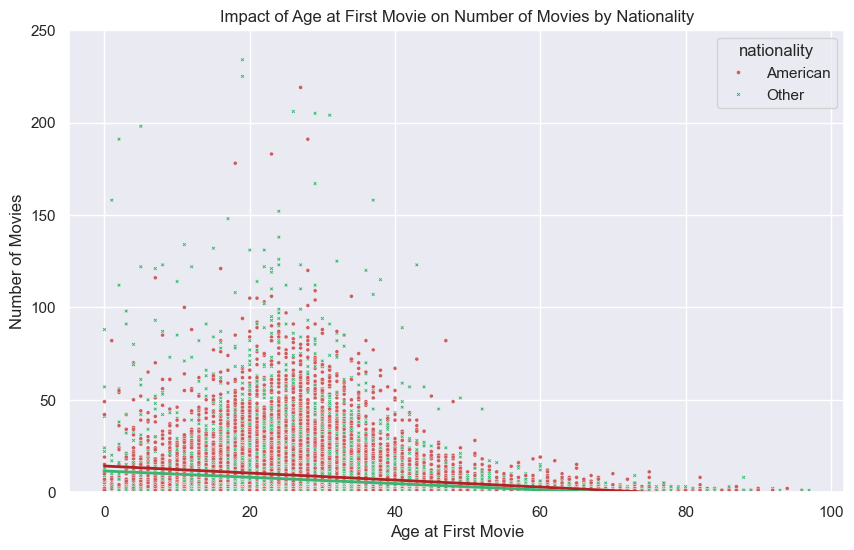

In [59]:
# Investigate the impact of age at first Movie on Number of Movies by nationality

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_actors,
    x='age_first_movie',
    y='number_of_movies',
    hue='nationality',
    palette={'American': 'indianred', 'Other': 'mediumseagreen'},
    style='nationality',
    s=8
)

# Regression line: US actors
sns.regplot(
    data=df_actors[df_actors['nationality'] == 'American'],
    x='age_first_movie',
    y='number_of_movies',
    scatter=False,           # No scatter points, line only
    color='firebrick',            # Color of regression line
    line_kws={'lw': 2}       # Line width
)

# Regression line: Foreign actors
sns.regplot(
    data=df_actors[df_actors['nationality'] == 'Other'],
    x='age_first_movie',
    y='number_of_movies',
    scatter=False,
    color='mediumseagreen',
    line_kws={'lw': 2} 
)

plt.title("Impact of Age at First Movie on Number of Movies by Nationality")
plt.xlabel("Age at First Movie")
plt.ylabel("Number of Movies")
plt.ylim(0,250)
plt.show()

As confirmed by the statistical tests below, a negative correlation exists between the age of the actor at the first movie and the number of movies acted in. It is also apparent in the plot, that this pattern is more pronounced for American actors compared to non-American actors, as American actors generally play in more movies than foreign actors. Based on these findings, it may be insightful to investigate whether American actors remain more successful than non-American actors when success is measured not by the number of movies acted in, but by factors such as box office performance or IMDb ratings of the movie.

An scatter plot may not be the best representation for this phenomon b

Note: here we cut out 2 (real) outliers:
- Mel Blanc: American actor with 791 movies
- Mithun Chakraborty: foreign actor with 328 movies

In [50]:
# Calculate Pearsons correlation for each nationality
corr_american = df_actors[df_actors['nationality'] == 'American'][['age_first_movie', 'number_of_movies']].corr().iloc[0, 1]
corr_other = df_actors[df_actors['nationality'] == 'Other'][['age_first_movie', 'number_of_movies']].corr().iloc[0, 1]

print(f"Correlation between age at first movie and number of movies for American actors: {corr_american:.3f}")
print(f"Correlation between age at first movie and number of movies for Other actors: {corr_other:.3f}")

Correlation between age at first movie and number of movies for American actors: -0.176
Correlation between age at first movie and number of movies for Other actors: -0.185


General comment: there is indeed a correlation with the age of the actors at their first movie and the number of movies they've acted in during their career. The relation is negative, which means that having an early career appearantly helps in kicking off the acting career (more movies done). Since US actors normally have earlier careers (plot before), we can deduce that being american in general helps in kicking off an acting career.

#### Does acting in an US movie help in kicking off the acting career?

In [51]:
# Striclty US movies

# Get the first US movie year for each actor
first_us_movie_year = us_movies.groupby('actor_name')['release_year'].min().reset_index()
first_us_movie_year.columns = ['actor_name', 'first_us_year']

# Merge this information back with the complete movies dataframe
df = all_movies.merge(first_us_movie_year, on='actor_name', how='left')
df = df[df['first_us_year'].notna()]

# Define 'period' by explicitly checking if the `release_year` is valid and comparing it to `first_us_year`
df['period'] = df.apply(
    lambda row: 'before' if pd.notna(row['release_year']) and row['release_year'] < row['first_us_year']
    else ('after' if pd.notna(row['release_year']) and row['release_year'] >= row['first_us_year'] 
          else None),
    axis=1
)

# Drop rows where 'period' is None
df = df.dropna(subset=['period'])

# Calculate the mean box office before and after for each actor
actor_means = df.groupby(['actor_name', 'period'])['box_office'].mean().unstack()

# Extract the 'before' and 'after' columns as separate arrays, filling NaNs with 0 where necessary
means_before = actor_means['before'].fillna(0).tolist()
means_after = actor_means['after'].fillna(0).tolist()

# Output: Two arrays with the box office means 
print("10 first Means Before First US Movie:", means_before[:10])
print("10 Means After First US Movie:", means_after[:10])

# Paired Sample t-test
t_stat, p_val_ttest = stats.ttest_rel(means_before, means_after)
print(f"Paired Sample t-test: t-statistic = {t_stat:.3f}, p-value = {p_val_ttest:.3f}")

# Wilcoxon Signed-Rank Test (Non-parametric alternative to the t-test)
w_stat, p_val_wilcoxon = stats.wilcoxon(means_before, means_after)
print(f"Wilcoxon Signed-Rank Test: statistic = {w_stat:.3f}, p-value = {p_val_wilcoxon:.3f}")

10 first Means Before First US Movie: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 Means After First US Movie: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63456988.0, 0.0, 4591629.0]
Paired Sample t-test: t-statistic = -75.286, p-value = 0.000
Wilcoxon Signed-Rank Test: statistic = 16158084.000, p-value = 0.000


In [52]:
# Partially US movies

# Get the first US movie year for each actor
first_us_par_movie_year = us_partially_movies.groupby('actor_name')['release_year'].min().reset_index()
first_us_par_movie_year.columns = ['actor_name', 'first_us_year']

# Merge this information back with the complete movies dataframe
df = all_movies.merge(first_us_par_movie_year, on='actor_name', how='left')
df = df[df['first_us_year'].notna()]

# Define 'period' by explicitly checking if the `release_year` is valid and comparing it to `first_us_year`
df['period'] = df.apply(
    lambda row: 'before' if pd.notna(row['release_year']) and row['release_year'] < row['first_us_year']
    else ('after' if pd.notna(row['release_year']) and row['release_year'] >= row['first_us_year'] 
          else None),
    axis=1
)

# Drop rows where 'period' is None
df = df.dropna(subset=['period'])

# Calculate the mean box office before and after for each actor
actor_means = df.groupby(['actor_name', 'period'])['box_office'].mean().unstack()

# Extract the 'before' and 'after' columns as separate arrays, filling NaNs with 0 where necessary
means_before = actor_means['before'].fillna(0).tolist()
means_after = actor_means['after'].fillna(0).tolist()

# Output: Two arrays with the box office means
print("10 first means Before First partially US Movie:", means_before[:10])
print("10 first means After First partially US Movie:", means_after[:10])

# Paired Sample t-test
t_stat, p_val_ttest = stats.ttest_rel(means_before, means_after)
print(f"Paired Sample t-test: t-statistic = {t_stat:.3f}, p-value = {p_val_ttest:.3f}")

# Wilcoxon Signed-Rank Test (Non-parametric alternative to the t-test)
w_stat, p_val_wilcoxon = stats.wilcoxon(means_before, means_after)
print(f"Wilcoxon Signed-Rank Test: statistic = {w_stat:.3f}, p-value = {p_val_wilcoxon:.3f}")   

10 first means Before First partially US Movie: [0.0, 0.0, 46442528.0, 0.0, 0.0, 0.0, 176182.5, 10409377.0, 0.0, 0.0]
10 first means After First partially US Movie: [0.0, 0.0, 27915879.4, 8500538.0, 44102389.0, 0.0, 52604.0, 52166399.5, 40795977.0, 0.0]
Paired Sample t-test: t-statistic = -44.392, p-value = 0.000
Wilcoxon Signed-Rank Test: statistic = 17163700.000, p-value = 0.000


General comment: the significance is really high (since < 0.05), i.e. there is a significant change in mean box office of the movies actors act in after acting in their first US produced movie, but it's also because we don't have much data about box office, maybe we could do the same but with IMDB ratings

#### Index of success : longevity of career + revenue of film + nb of films acted

In [53]:
# See if for American actors it is easier to act in famous movies
# Select famous movies

# Strictly US
famous_us_movie_df = us_movies.sort_values('box_office', ascending = False)
len_revenue = int(len(famous_us_movie_df) * 0.1)
top_10_percent_us_movies = famous_us_movie_df.head(len_revenue)

# Partially US
famous_us_part_movie_df = us_partially_movies.sort_values('box_office', ascending = False)
len_part_revenue = int(len(famous_us_part_movie_df) * 0.1)
top_10_percent_us_part_movies = famous_us_part_movie_df.head(len_part_revenue)

# Rest of the world
famous_world_movie_df = us_partially_movies.sort_values('box_office', ascending = False)
len_world_revenue = int(len(famous_world_movie_df) * 0.1)
top_10_percent_world_movies = famous_world_movie_df.head(len_world_revenue)

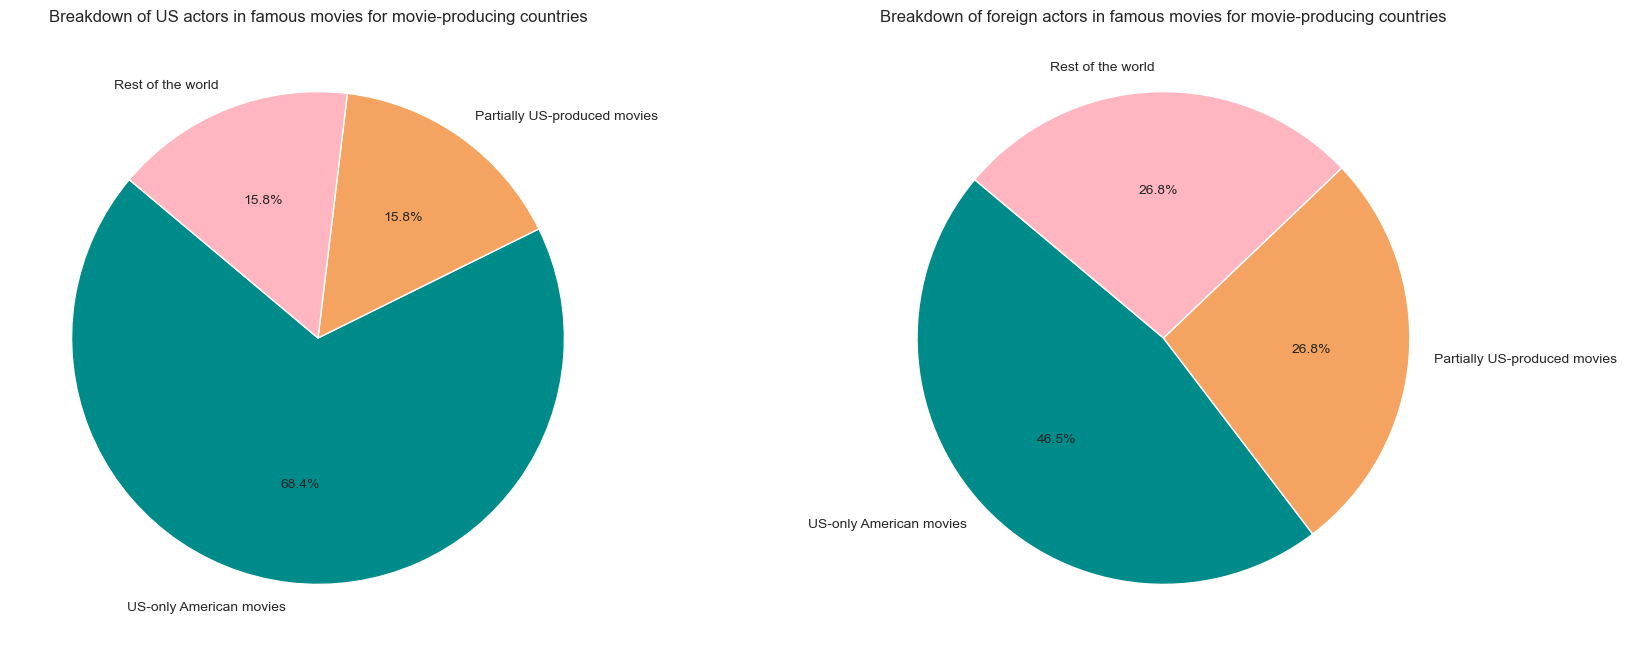

In [54]:
# US actors
us_fam_us_movies = top_10_percent_us_movies.loc[top_10_percent_us_movies['nationality'] == 'American']
us_fam_us_part_movies = top_10_percent_us_part_movies.loc[top_10_percent_us_part_movies['nationality'] == 'American']
us_fam_world_movies = top_10_percent_world_movies.loc[top_10_percent_world_movies['nationality'] == 'American']
fam_us_counts = [len(us_fam_us_movies['actor_name'].unique()),len(us_fam_us_part_movies['actor_name'].unique()),len(us_fam_world_movies['actor_name'].unique())]

# Foreign actors
for_fam_us_movies = top_10_percent_us_movies.loc[top_10_percent_us_movies['nationality'] == 'Other']
for_fam_us_part_movies = top_10_percent_us_part_movies.loc[top_10_percent_us_part_movies['nationality'] ==  'Other']
for_fam_world_movies= top_10_percent_world_movies.loc[top_10_percent_world_movies['nationality'] == 'Other']
fam_for_counts = [len(for_fam_us_movies['actor_name'].unique()),len(for_fam_us_part_movies['actor_name'].unique()),len(for_fam_world_movies['actor_name'].unique())]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.pie(
    fam_us_counts,
    labels= ['US-only American movies', 'Partially US-produced movies' , 'Rest of the world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
ax1.set_title("Breakdown of US actors in famous movies for movie-producing countries")

ax2.pie(
    fam_for_counts,
    labels= ['US-only American movies', 'Partially US-produced movies' , 'Rest of the world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
ax2.set_title("Breakdown of foreign actors in famous movies for movie-producing countries")

plt.show()

The plot shows, that American actors play more often in successful American movies than foreign actors do.

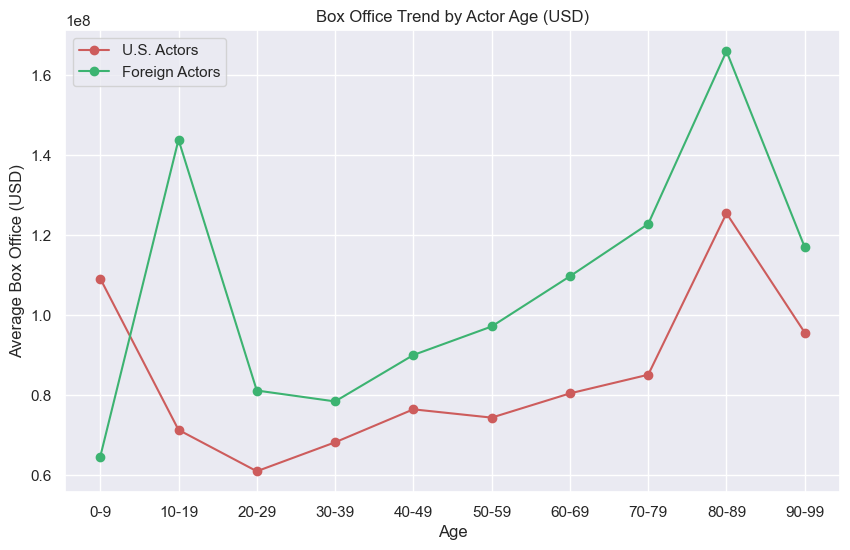

In [55]:
# Plot the revenue based on the age for the two groups

us_revenue_by_age = total_us_actors.groupby('age_at_release')['box_office'].mean().reset_index()
foreign_revenue_by_age = total_for_actors.groupby('age_at_release')['box_office'].mean().reset_index()

# Too messy, divide in age groups
plt.figure(figsize=(10, 6))
bins = range(0, 101, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Create labels for bins

total_us_actors['age_group'] = pd.cut(total_us_actors['age_at_release'], bins=bins, labels=labels, right=False)
us_revenue_by_age = total_us_actors.groupby('age_group')['box_office'].mean().reset_index()

# Bin the ages into 10-year groups for Foreign actors
total_for_actors['age_group'] = pd.cut(total_for_actors['age_at_release'], bins=bins, labels=labels, right=False)
foreign_revenue_by_age = total_for_actors.groupby('age_group')['box_office'].mean().reset_index()

plt.plot(us_revenue_by_age['age_group'], us_revenue_by_age['box_office'], marker='o', label='U.S. Actors', color='indianred')
plt.plot(foreign_revenue_by_age['age_group'], foreign_revenue_by_age['box_office'], marker='o', label='Foreign Actors', color='mediumseagreen')

# Adding titles and labels
plt.title('Box Office Trend by Actor Age (USD)')
plt.xlabel('Age')
plt.ylabel('Average Box Office (USD)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Interestingly, foreign actors play in more successful movies in terms of box office compared to American actors. This holds for every age group except for actors younger than 10 years old. 

However, the number of actors per age group varies a lot which might lead to a distortion of the average box office revenue of the movies they played in. 
Hence, drawing conclusions first requires a refinement of this analysis. An option is, considereing only the top_10 percent of movies for example in terms of box office.

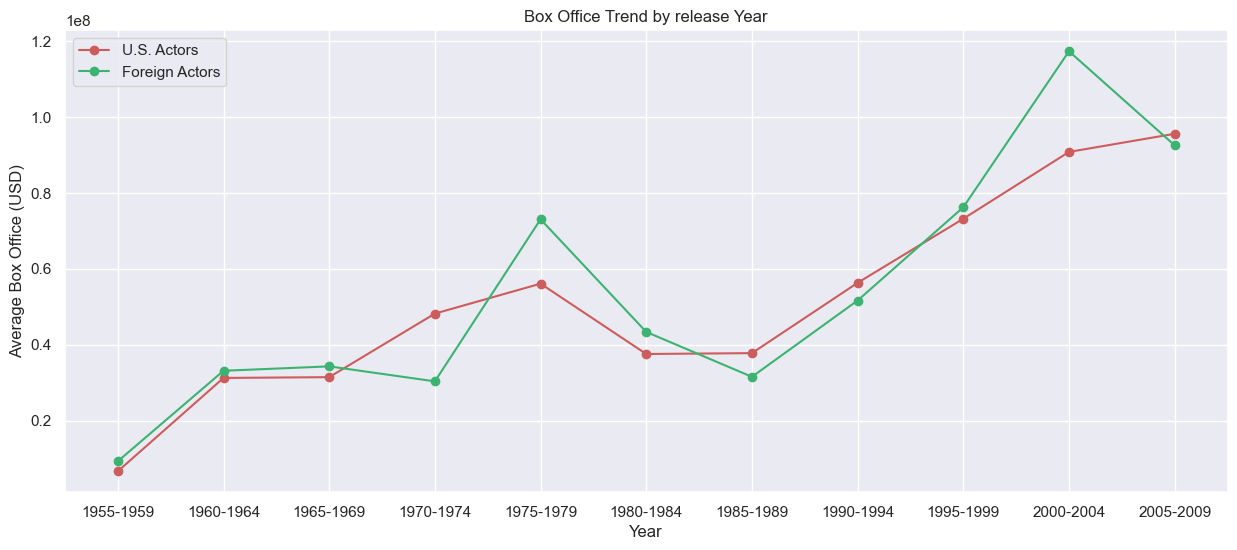

In [56]:
# See how this revenue trend changed during the years

us_revenue_by_year = total_us_actors.groupby('release_year')['box_office'].mean().reset_index()
foreign_revenue_by_year = total_for_actors.groupby('release_year')['box_office'].mean().reset_index()

# Too messy, divide in age groups
plt.figure(figsize=(15, 6))
bins = range(1955, 2015, 5) # I checked before for min and max
labels = [f'{i}-{i+4}' for i in bins[:-1]]  # Create labels for bins

total_us_actors['year_group'] = pd.cut(total_us_actors['release_year'], bins=bins, labels=labels, right=False)
us_revenue_by_year = total_us_actors.groupby('year_group')['box_office'].mean().reset_index()

# Bin the ages into 10-year groups for Foreign actors
total_for_actors['year_group'] = pd.cut(total_for_actors['release_year'], bins=bins, labels=labels, right=False)
foreign_revenue_by_year = total_for_actors.groupby('year_group')['box_office'].mean().reset_index()

plt.plot(us_revenue_by_year['year_group'], us_revenue_by_year['box_office'], marker='o', label='U.S. Actors', color='indianred')
plt.plot(foreign_revenue_by_year['year_group'], foreign_revenue_by_year['box_office'], marker='o', label='Foreign Actors', color='mediumseagreen')

# Adding titles and labels
plt.title('Box Office Trend by release Year')
plt.xlabel('Year')
plt.ylabel('Average Box Office (USD)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

The observed increase of box office revenue over time is to be expected for a variety of reasons that can include currancy development. The evolution of the box office in movies in which American actors played behaves similary to the one of foreign actors. There is no direct difference visible. Here as well, better refinement which will be done in future could bring more valuable insights on this dataseries.

Cluster Medians:
              career_length  number_of_movies  age_first_movie
career_type                                                  
0                      4.0               1.0             32.0
1                     28.0              11.0             26.0
2                      1.0               2.0             21.0
3                      0.0               1.0             50.0
4                     36.0              49.0             24.0

Cluster Standard Deviations:
              career_length  number_of_movies  age_first_movie
career_type                                                  
0                 6.482447          2.235858         4.737029
1                10.113549          8.873416         8.621167
2                 4.308051          3.446503         5.817530
3                 5.166113          1.909518         9.695271
4                13.201918         33.496531         8.129678


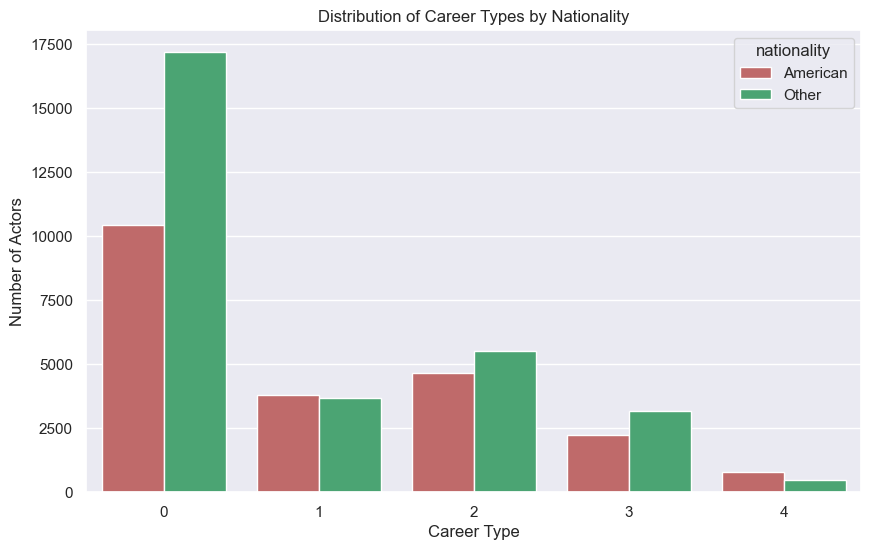

In [57]:
# We use K-means to identify differences in career-types
# Are non-U.S. actors more likely to have short, prolific careers? Do U.S. actors have more long, steady careers?

# Select features and standardize
df_actors['career_length'] = df_actors['age_last_movie'] - df_actors['age_first_movie']

X = df_actors[['career_length', 'number_of_movies', 'age_first_movie']].apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Fit KMeans with 3 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
df_actors['career_type'] = kmeans.fit_predict(X_scaled)

# Calculate median and standard deviation for each feature within each cluster
cluster_median = df_actors.groupby('career_type')[['career_length', 'number_of_movies', 'age_first_movie']].median()
cluster_std = df_actors.groupby('career_type')[['career_length', 'number_of_movies', 'age_first_movie']].std()

print("Cluster Medians:\n", cluster_median)
print("\nCluster Standard Deviations:\n", cluster_std)

# Plot career types by nationality
plt.figure(figsize=(10, 6))
sns.countplot(x='career_type', hue='nationality', data=df_actors, palette={'American': 'indianred', 'Other': 'mediumseagreen'})
plt.title('Distribution of Career Types by Nationality')
plt.xlabel('Career Type')
plt.ylabel('Number of Actors')
plt.show()

Interpretation of clusters (career types):
- 0: short and coincise career
- 1: long and active career
- 2: short and early career
- 3: short and late career
- 4: long, active and early career

Most actors visibly belong to group 0, characterized by a short and concise career. The proportion of American actors with such careers is smaller compared to that of foreign actors. Therefore, this relatively unsuccessful career path is more common among foreign actors than American actors.

Additionally, more American actors than foreign actors are found in group 4, which represents actors with long, active, and early-starting careers. This group likely corresponds to very successful actors and is noticeably composed of more Americans than foreign actors.

This analysis could be further refined by focusing only on actors appearing in the most successful movies, such as those measured by box office revenue or IMDb ratings. On the other hand, custering the career types for only American movies might also be insightful concerning character types appearing in American movies to analyse, which personas are transported to the spectator through cinema.

Later, we will better the kmeans using elbow/silhouette and including more variables to cluster onto.